Day 1 

I) Implementation of different estimators 

In [54]:
import numpy as np
import pandas as pd
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from arch import arch_model
warnings.filterwarnings("ignore")
from fbm import fbm, times
from scipy import stats
from sklearn.metrics import r2_score

Import of SPY data

In [55]:
data = yf.download('SPY', start='2000-01-01', end='2014-01-01')

[*********************100%%**********************]  1 of 1 completed


Close to close estimator 

In [56]:
def close_to_close(data):
    data['Close-to-close'] = np.abs(np.log(data['Close'] / data['Close'].shift(1)))
    Close_to_close=data['Close-to-close']
    return Close_to_close

Parkinson estimator 

In [57]:
def Parkinson(data):
    Parkinson = np.sqrt(1 / (4 * np.log(2)) * np.log(data['High'] / data['Low']) ** 2)
    return Parkinson

Garman Klass estimator

In [58]:
def garman_klass__estimator(data):
    sigma_GK = 0.5 * (np.log(data['High']/data['Low']))**2 - (2*np.log(2)-1) * (np.log(data['Close']/data['Open']))**2
    sigma_GK = np.sqrt(sigma_GK)
    return sigma_GK

Roger Satchell estimator

In [59]:
def rogers_satchell_volatility(data):
    high = data['High']
    low = data['Low']
    close = data['Close']
    open = data['Open']

    log_hc = np.log(high / close)
    log_ho = np.log(high / open)
    log_lc = np.log(low / close)
    log_lo = np.log(low / open)

    sigma_rs = np.sqrt(log_hc * log_ho + log_lc * log_lo)
    return sigma_rs

Yang-Zhang estimator

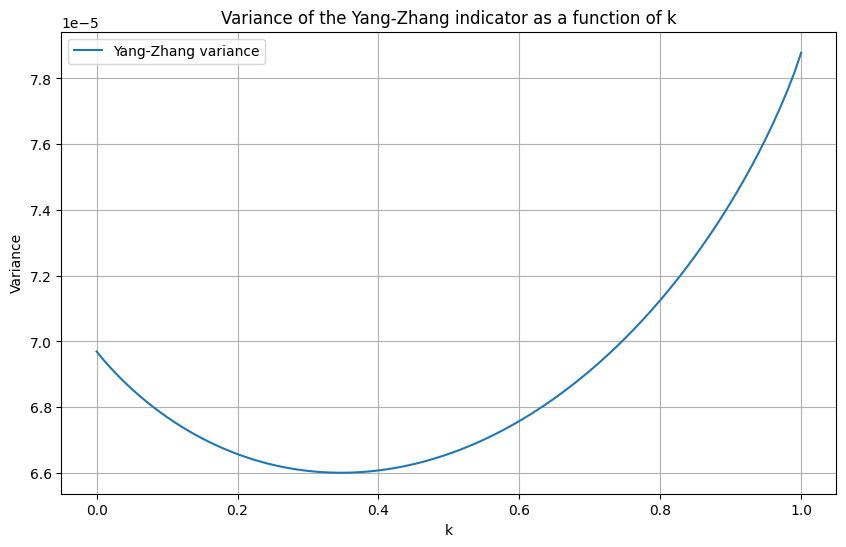

In [60]:

def calculate_yang_zhang(data, k):
    yang_zhang = np.sqrt(
        np.log(data['Open'] / data['Close'].shift(1)) ** 2
        + k * np.log(data['Close'] / data['Open']) ** 2
        + (1 - k) * (np.log(data['High'] / data['Close']) * np.log(data['High'] / data['Open'])
                  + np.log(data['Low'] / data['Close']) * np.log(data['Low'] / data['Open'])))
    
    return yang_zhang

# Variance of the Yang-Zhang indicator as a function of k
def plot_yang_zhang_variance(data):
    k_values = np.linspace(0, 1, 100)
    variances = []

    for k in k_values:
        yang_zhang = calculate_yang_zhang(data, k)
        variances.append(np.var(yang_zhang))

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, variances, label='Yang-Zhang variance')
    plt.xlabel('k')
    plt.ylabel('Variance')
    plt.title('Variance of the Yang-Zhang indicator as a function of k')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_yang_zhang_variance(data)

Graphs 

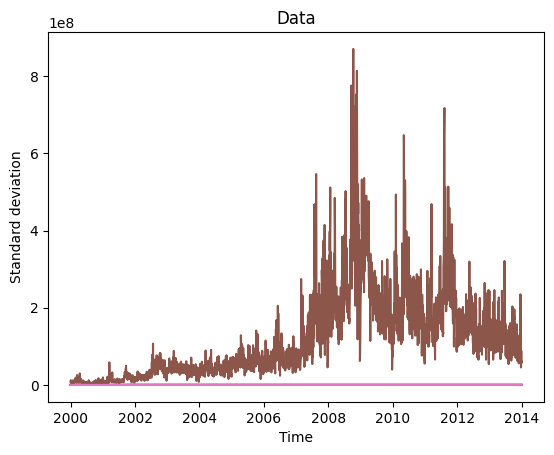

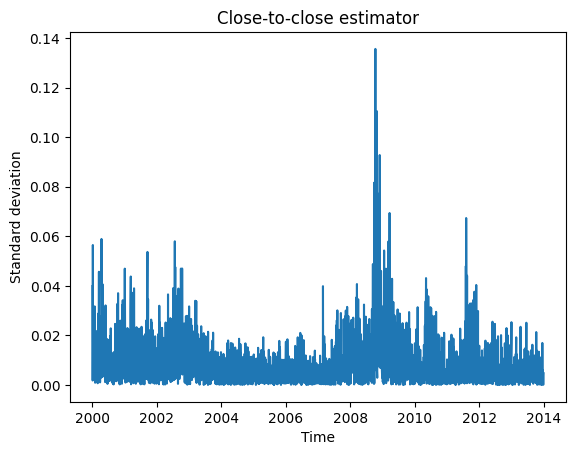

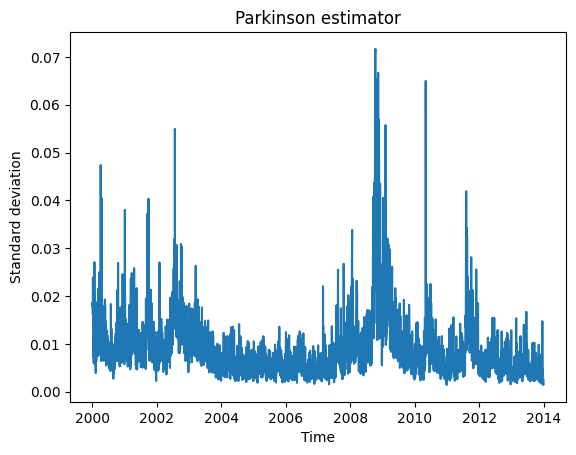

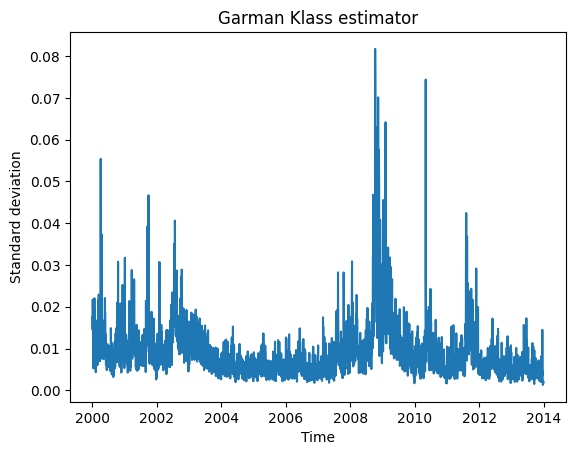

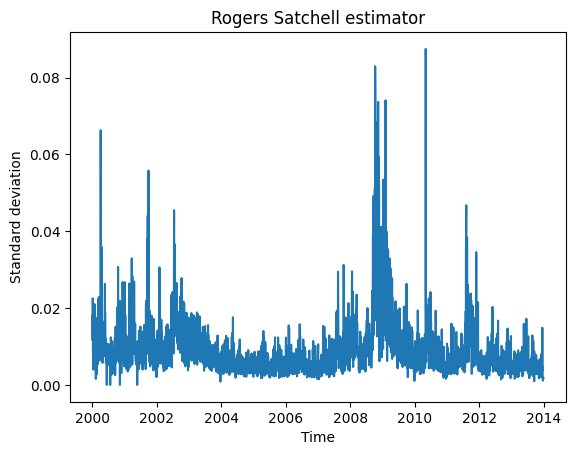

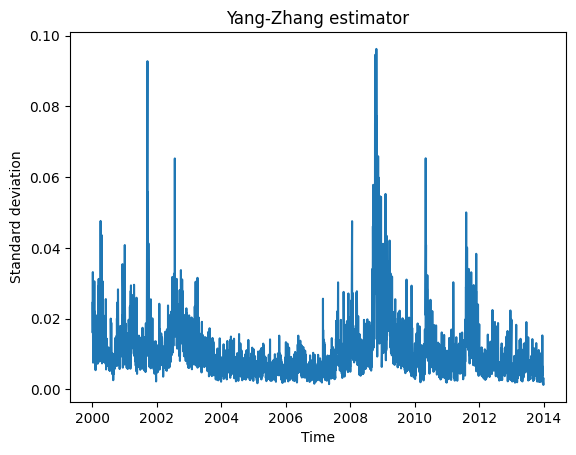

In [61]:
parkinson_data = Parkinson(data) 
garman_data = garman_klass__estimator(data) 
rogers_data = rogers_satchell_volatility(data) 
close_data = close_to_close(data) 

plt.plot(data)
plt.title('Data')
plt.xlabel('Time')
plt.ylabel('Standard deviation')
plt.show()

plt.plot(close_data)
plt.title('Close-to-close estimator')
plt.ylabel('Standard deviation')
plt.xlabel('Time')
plt.show()


plt.plot(parkinson_data)
plt.title('Parkinson estimator')
plt.ylabel('Standard deviation')
plt.xlabel('Time')
plt.show()


plt.plot(garman_data)
plt.title('Garman Klass estimator')
plt.ylabel('Standard deviation')
plt.xlabel('Time')
plt.show()

plt.plot(rogers_data)
plt.title('Rogers Satchell estimator')
plt.ylabel('Standard deviation')
plt.xlabel('Time')
plt.show()

yangzhang= calculate_yang_zhang(data,k=0.5)

plt.plot(yangzhang)
plt.title('Yang-Zhang estimator')
plt.ylabel('Standard deviation')
plt.xlabel('Time')
plt.show()

II) Comparison between estimators 

### Calculation of the correlation matrix for all the estimators

In [62]:
data = yf.download('SPY', start='2000-01-01', end='2014-01-01')

k = 1 

#preparation of the data for each estimator
A = pd.Series(close_to_close(data)[1:])
B = pd.Series(garman_klass__estimator(data))
C = pd.Series(Parkinson(data))
D = pd.Series(rogers_satchell_volatility(data)[1:])
E = pd.Series(calculate_yang_zhang(data, k)[1:])

estimators = [A, B, C, D, E]

# calculation of the correlation matrix
correlation_matrix = np.zeros((5, 5))
for i in range(len(estimators)):
    for j in range(len(estimators)):
        correlation_matrix[i, j] = estimators[i].corr(estimators[j])

#display of the correlations
labels = ['Close to Close', 'Garman Klass', 'Parkinson', 'Roger Satchell', 'Yang Zhang']
df_correlation = pd.DataFrame(correlation_matrix, index=labels, columns=labels)

print(df_correlation)


[*********************100%%**********************]  1 of 1 completed

                Close to Close  Garman Klass  Parkinson  Roger Satchell  \
Close to Close        1.000000      0.621091   0.731183        0.522487   
Garman Klass          0.621091      1.000000   0.967018        0.979675   
Parkinson             0.731183      0.967018   1.000000        0.902979   
Roger Satchell        0.522487      0.979675   0.902979        1.000000   
Yang Zhang            0.848369      0.695364   0.828181        0.576099   

                Yang Zhang  
Close to Close    0.848369  
Garman Klass      0.695364  
Parkinson         0.828181  
Roger Satchell    0.576099  
Yang Zhang        1.000000  


### Calculation of the correlation between the estimators and the true volatility

In [63]:
import warnings
warnings.filterwarnings("ignore")

#filtering of the data to erase all the "NaN" types (showing "nan"), working more effectively than the regular .dropna()
data_frame = pd.read_csv("RealizedVarianceData.csv")
a=pd.read_csv("RealizedVarianceData.csv",skiprows=[0])
d=a["SPX2.rv"].tolist()
for k in range(len(d)):
    if str(d[k])=="nan":
        d[k]=d[k-1]

true_volatility = pd.Series(d)
true_volatility = true_volatility.dropna()
estimators = [pd.Series(estimator) for estimator in estimators] 

#calculation of the correlations with the true data
correlation_with_true_vol = np.zeros(5)
for i in range(len(correlation_with_true_vol)):
    if not any(pd.isna(true_volatility)) and not any(pd.isna(estimators[i])):   #to avoid all warnings and errors
        d=estimators[i].tolist()
        for k in range(len(d)):
            if str(d[k])=="nan":
                 d[k]=d[k-1]
        correlation_with_true_vol[i] = pd.Series(d).corr(true_volatility)

df_corr_true_vol = pd.DataFrame([correlation_with_true_vol], columns=labels)
print("Correlation with True Volatility:\n", df_corr_true_vol)

Correlation with True Volatility:
    Close to Close  Garman Klass  Parkinson  Roger Satchell  Yang Zhang
0        0.144504      0.234906   0.230696        0.212936    0.168274


### Plot of the MSE for each estimator of the volatility

[*********************100%%**********************]  1 of 1 completed


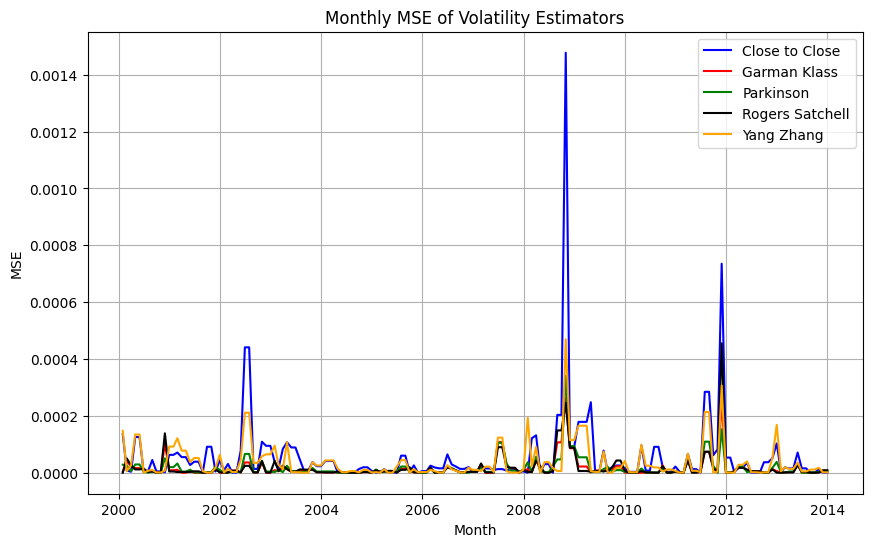

In [65]:
#preparation of the data
data['Date'] = data.index
data['Month'] = data['Date'].dt.to_period('M')
data = yf.download('SPY', start='2000-01-01', end='2014-01-01')
data.index = pd.to_datetime(data.index)
true_volatility = d

data['Estimator1'] = close_to_close(data)
data['Estimator2'] = garman_klass__estimator(data)  
data['Estimator3'] = Parkinson(data)     
data['Estimator4'] = rogers_satchell_volatility(data)
data['Estimator5'] = calculate_yang_zhang(data, k=1)  


data['True_Volatility'] = [0]+true_volatility
monthly_true_volatility = data['True_Volatility'].resample('M').mean()

#calculation of all the MSE for each estimator on a monthly basis
def calculate_monthly_mse(estimator, true_volatility):
    return ((estimator - true_volatility) ** 2).resample('M').mean()

monthly_mse = pd.DataFrame({
    'Estimator1': calculate_monthly_mse(data['Estimator1'], monthly_true_volatility),
    'Estimator2': calculate_monthly_mse(data['Estimator2'], monthly_true_volatility),
    'Estimator3': calculate_monthly_mse(data['Estimator3'], monthly_true_volatility),
    'Estimator4': calculate_monthly_mse(data['Estimator4'], monthly_true_volatility),
    'Estimator5': calculate_monthly_mse(data['Estimator5'], monthly_true_volatility)
})

plt.figure(figsize=(10, 6))
plt.plot(monthly_mse.index.tolist(), monthly_mse['Estimator1'].fillna(method='bfill').tolist(), label='Close to Close', color='blue')
plt.plot(monthly_mse.index.tolist(), monthly_mse['Estimator2'].fillna(method='bfill').tolist(), label='Garman Klass', color='red')
plt.plot(monthly_mse.index.tolist(), monthly_mse['Estimator3'].fillna(method='bfill').tolist(), label='Parkinson', color='green')
plt.plot(monthly_mse.index.tolist(), monthly_mse['Estimator4'].fillna(method='bfill').tolist(), label='Rogers Satchell', color='black')
plt.plot(monthly_mse.index.tolist(), monthly_mse['Estimator5'].fillna(method='bfill').tolist(), label='Yang Zhang', color='orange')

plt.title('Monthly MSE of Volatility Estimators')
plt.xlabel('Month')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

### Plots of the distribution of the MSE for each estimator

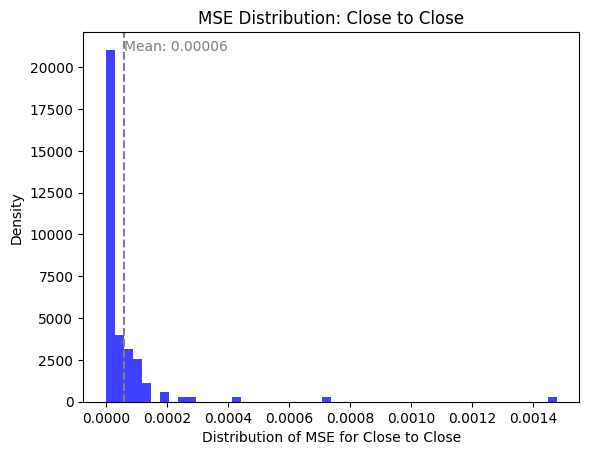

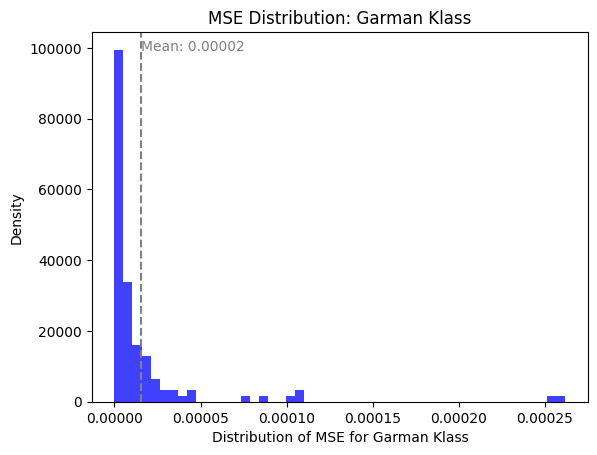

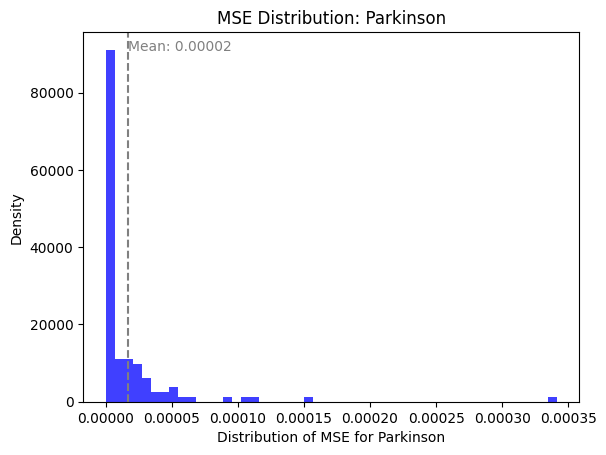

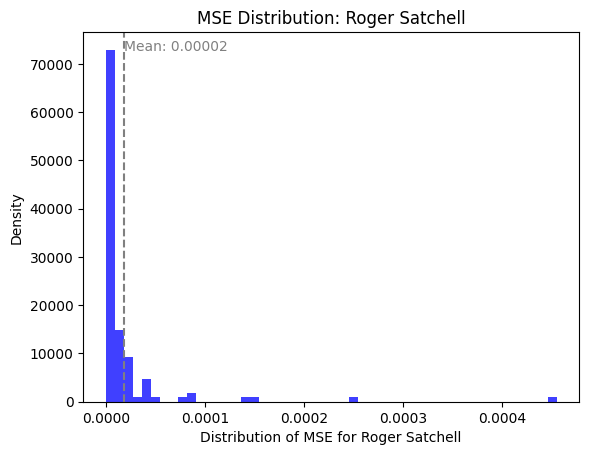

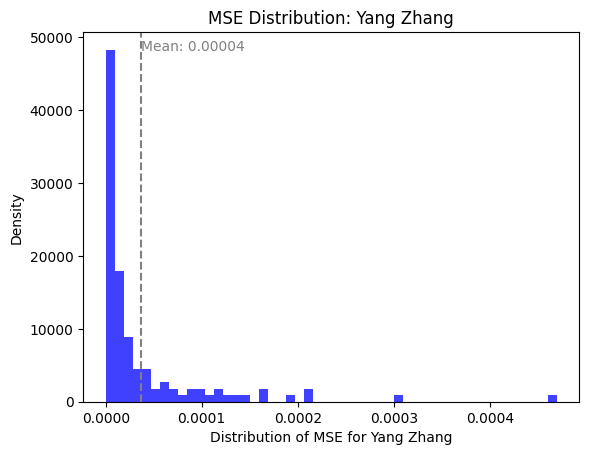

Estimators sorted from least to most biased based on MSE:
Garman Klass: 1.5709788398657358e-05
Parkinson: 1.6744139691732564e-05
Roger Satchell: 1.8231708374086943e-05
Yang Zhang: 3.698073708260585e-05
Close to Close: 5.881714504740135e-05


In [66]:

legends = ['Close to Close', 'Garman Klass', 'Parkinson', 'Roger Satchell', 'Yang Zhang']

mse_means = {}  

for i in range(1, 6):
    x = f'Estimator{i}'
    liste = monthly_mse[x].tolist() #calculation of each MSE on a monthly basis

    mean_mse = np.nanmean(liste)
    mse_means[legends[i-1]] = mean_mse  # Store each mean in a dictionnary for later comparison 

    density, bins, _ = plt.hist(liste, bins=50, alpha=0.75, color='blue', density=True)
    plt.xlabel(f'Distribution of MSE for {legends[i-1]}')
    plt.ylabel('Density')
    plt.axvline(x=mean_mse, color='gray', linestyle='--')
    plt.text(mean_mse, plt.ylim()[1] * 0.95, f'Mean: {mean_mse:.5f}', color='gray', ha='left')
    plt.title(f'MSE Distribution: {legends[i-1]}')
    plt.show()

sorted_means = sorted(mse_means.items(), key=lambda item: item[1])  #comparison of the estimators based on their MSE means over the whole period
print("Estimators sorted from least to most biased based on MSE:")
for estimator, mse in sorted_means:
    print(f"{estimator}: {mse}")



### Plots of the distribution of the bias for each estimator

In [67]:

#preparation of the data for the calculation of the bias for each month and estimator

monthly_true_volatility = data['True_Volatility'].resample('M').mean()
data['True_Volatility'] = data['Close'].pct_change().rolling(window=30).std()

def calculate_monthly_mean(estimateur):
    return estimateur.resample('M').mean()

def calculate_monthly_bias(estimator, true_volatility):
    return (true_volatility-calculate_monthly_mean(estimator))

monthly_bias = pd.DataFrame({
    'Estimator1': calculate_monthly_bias(data['Estimator1'], data['True_Volatility']),
    'Estimator2': calculate_monthly_bias(data['Estimator2'], data['True_Volatility']),
    'Estimator3': calculate_monthly_bias(data['Estimator3'], data['True_Volatility']),
    'Estimator4': calculate_monthly_bias(data['Estimator4'], data['True_Volatility']),
    'Estimator5': calculate_monthly_bias(data['Estimator5'], data['True_Volatility'])
})

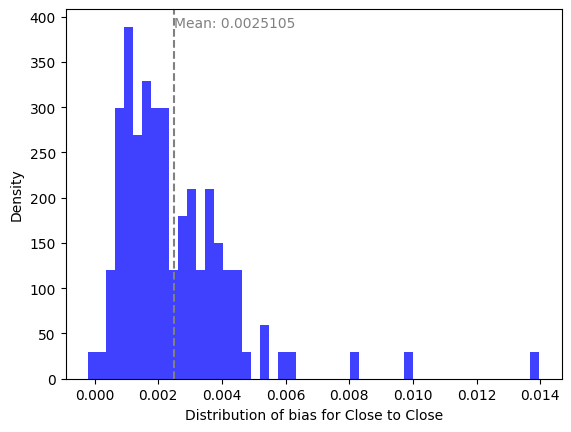

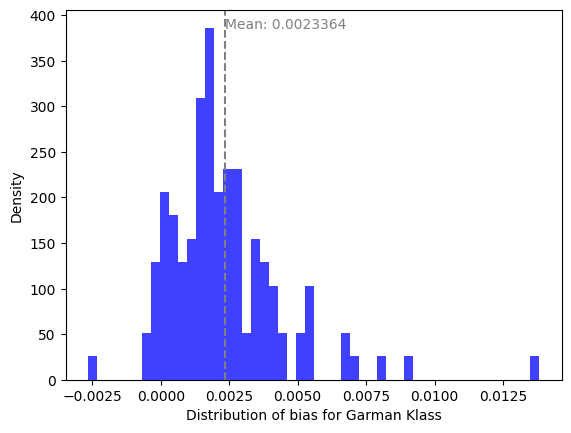

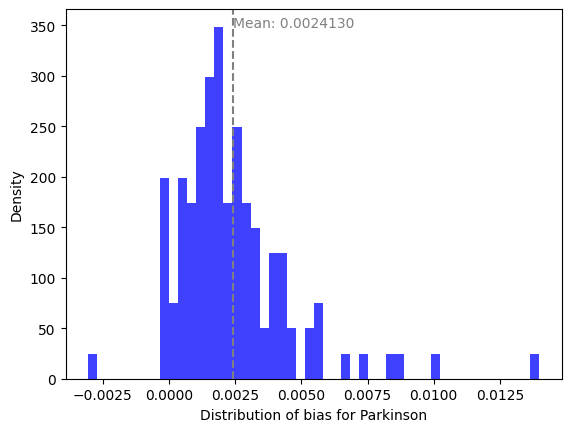

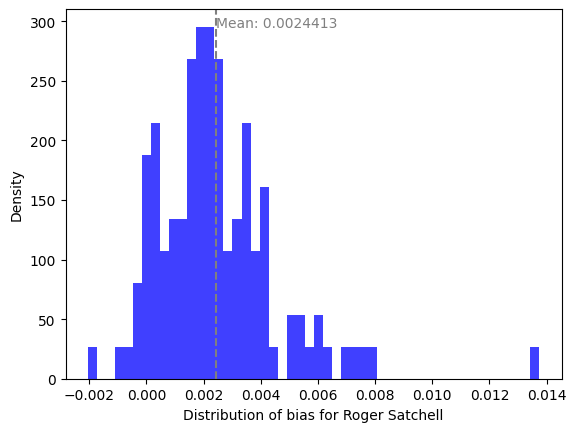

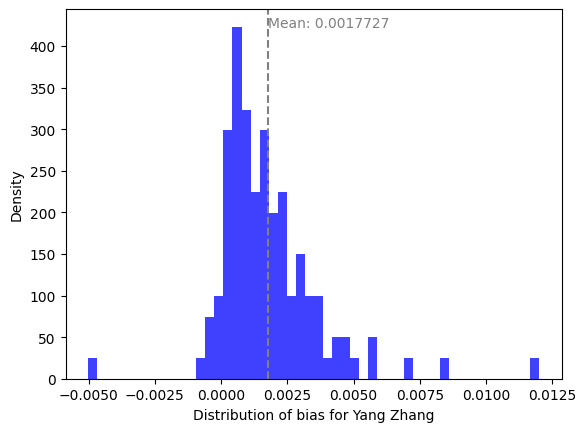

Estimators sorted from least to most biased based on MSE:
Yang Zhang: 0.0017727063642614868
Garman Klass: 0.0023364272188480272
Parkinson: 0.0024130028791542945
Roger Satchell: 0.002441267428890797
Close to Close: 0.0025104950959297426


In [68]:

bias_means = {}

for i in range (1,6):

    x = f'Estimator{i}'
    liste = monthly_bias[x].tolist()
    bias_means[legends[i-1]] = np.nanmean(liste)

    density, bins, _ = plt.hist(liste, bins=50, alpha=0.75, color='blue', density=True)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    plt.xlabel(f'Distribution of bias for {legends[i-1]}')
    plt.ylabel('Density')
    plt.axvline(x=np.nanmean(liste),color='gray',linestyle='--')
    plt.text(np.nanmean(liste), plt.ylim()[1] * 0.95, f'Mean: {np.nanmean(liste):.7f}', color='gray', ha='left')
    plt.show()

#same sorting than for the MSE, for comparison
sorted_estimators = sorted(bias_means.items(), key=lambda item: item[1])

print("Estimators sorted from least to most biased based on MSE:")
for estimator, bias in sorted_estimators:
    print(f"{estimator}: {bias}")

### Plot of the distribution of the ratios of variances for every combination of estimators

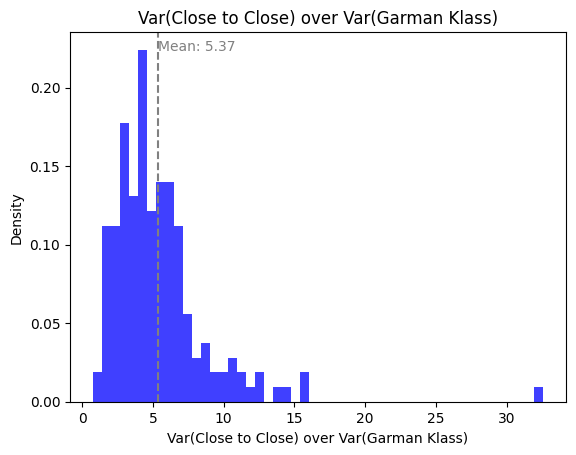

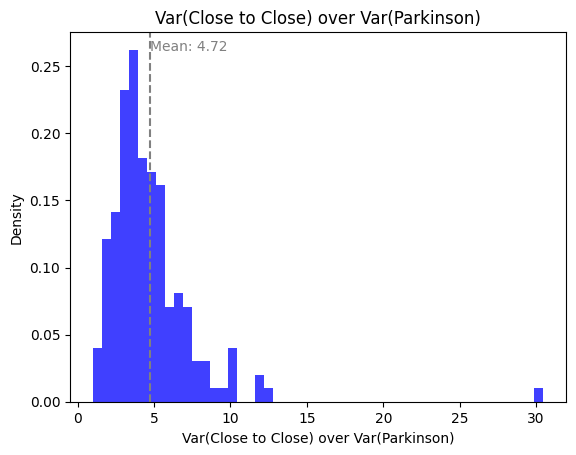

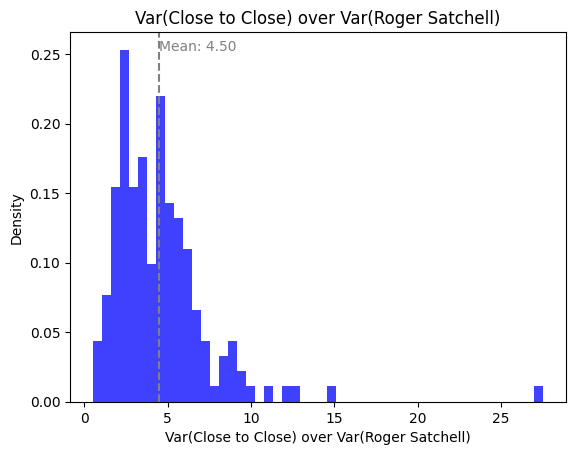

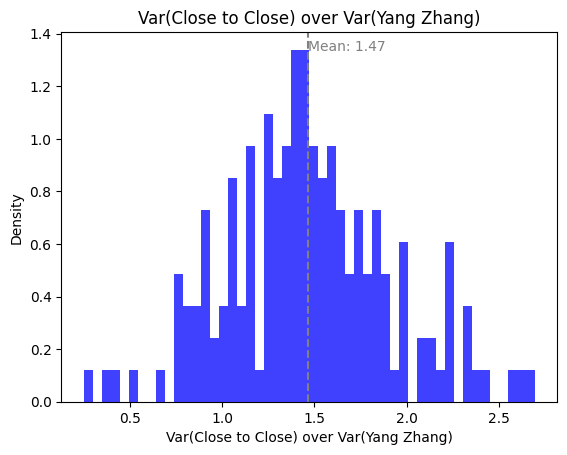

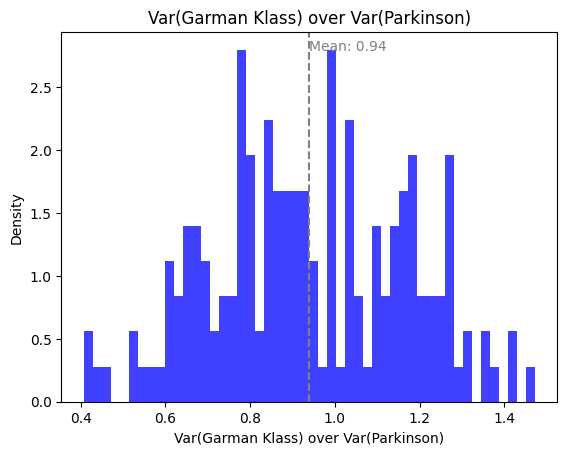

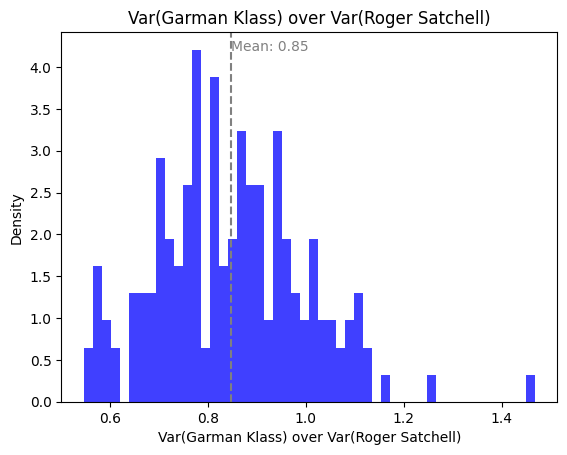

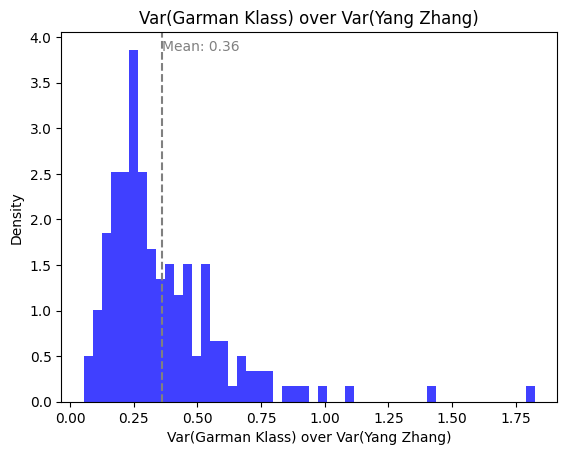

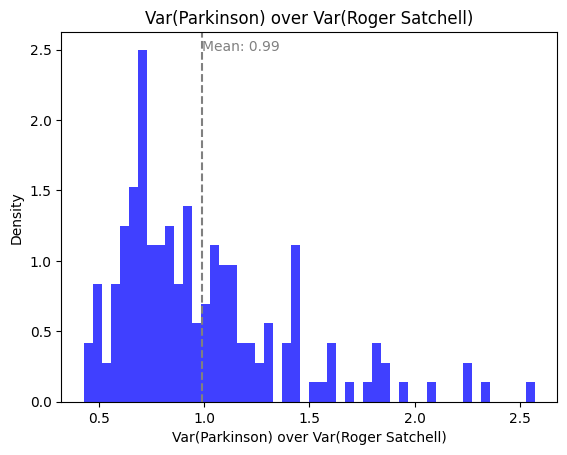

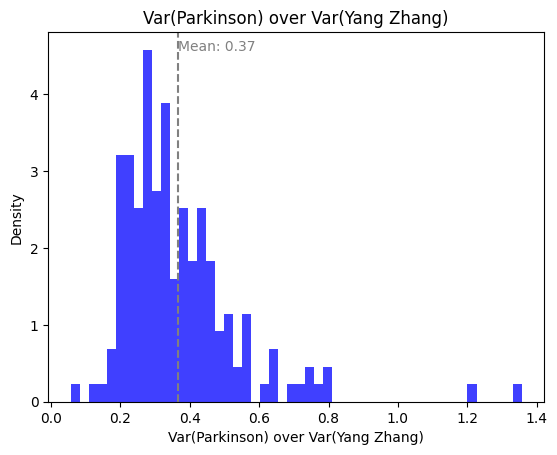

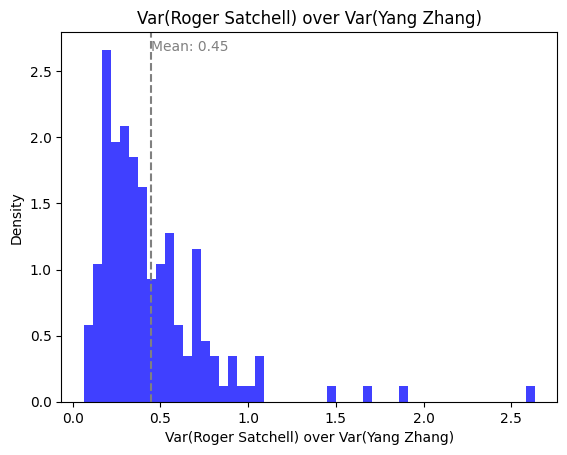

Var(Garman Klass) over Var(Yang Zhang): 0.36
Var(Parkinson) over Var(Yang Zhang): 0.37
Var(Roger Satchell) over Var(Yang Zhang): 0.45
Var(Garman Klass) over Var(Roger Satchell): 0.85
Var(Garman Klass) over Var(Parkinson): 0.94
Var(Parkinson) over Var(Roger Satchell): 0.99
Var(Close to Close) over Var(Yang Zhang): 1.47
Var(Close to Close) over Var(Roger Satchell): 4.50
Var(Close to Close) over Var(Parkinson): 4.72
Var(Close to Close) over Var(Garman Klass): 5.37


In [69]:

def calculate_monthly_var(estimator):
    return estimator.resample('M').var()

monthly_var = pd.DataFrame({
    'Estimator1': calculate_monthly_var(data['Estimator1']),
    'Estimator2': calculate_monthly_var(data['Estimator2']),
    'Estimator3': calculate_monthly_var(data['Estimator3']),
    'Estimator4': calculate_monthly_var(data['Estimator4']),
    'Estimator5': calculate_monthly_var(data['Estimator5'])
})

div = lambda l1, l2: [l1[k]/l2[k] for k in range(len(l1))]

variance_ratios_means = {}

for i in range(1, 6):   #each combination of two distinct estimators is tested
    for j in range(i+1, 6):
        x = f'Estimator{i}'
        y = f'Estimator{j}'
        liste_x = monthly_var[x].tolist()
        liste_y = monthly_var[y].tolist()
        ratio_list = div(liste_x, liste_y)  #list for all ratios of variances

        mean_ratio = np.nanmean(ratio_list)
        key_name = f'Var({legends[i-1]}) over Var({legends[j-1]})'
        variance_ratios_means[key_name] = mean_ratio
        
        density, bins, _ = plt.hist(ratio_list, bins=50, alpha=0.75, color='blue', density=True)
        plt.xlabel(key_name)
        plt.ylabel('Density')
        plt.axvline(x=mean_ratio, color='gray', linestyle='--')
        plt.text(mean_ratio, plt.ylim()[1] * 0.95, f'Mean: {mean_ratio:.2f}', color='gray', ha='left')
        plt.title(key_name)
        plt.show()

sorted_means = sorted(variance_ratios_means.items(), key=lambda item: item[1])
for name, mean in sorted_means:
    print(f"{name}: {mean:.2f}")



### Plots of the distribution of the variance for each estimator

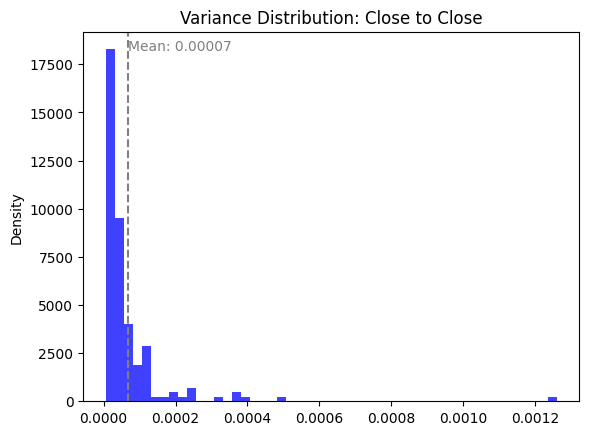

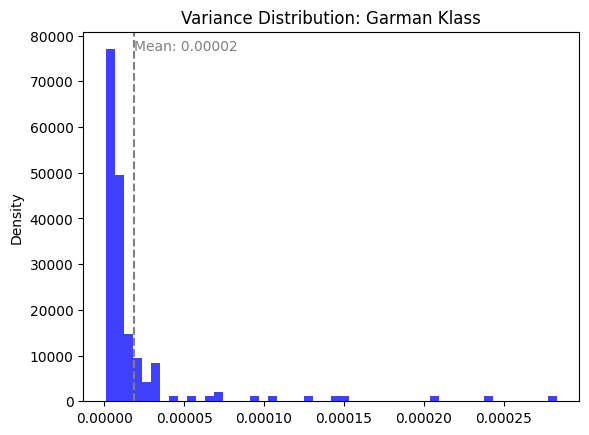

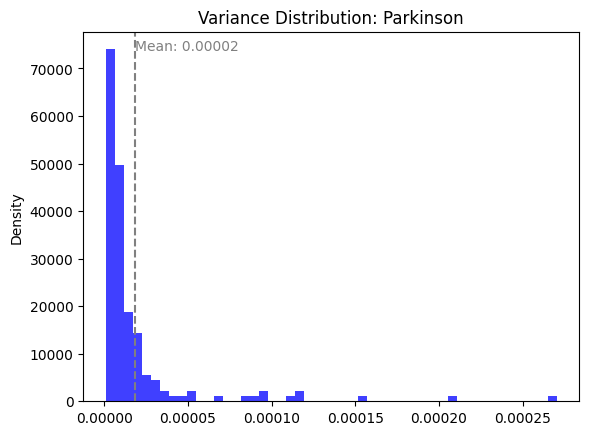

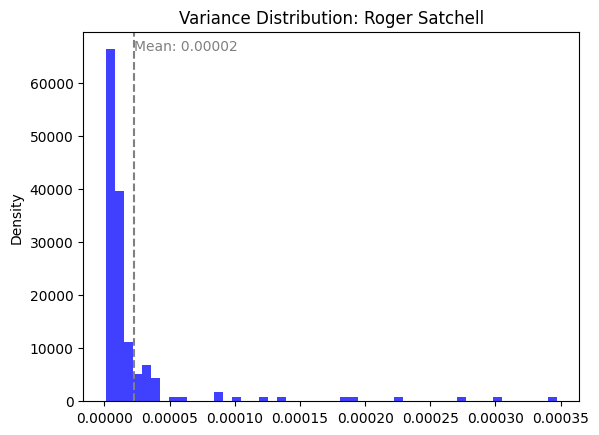

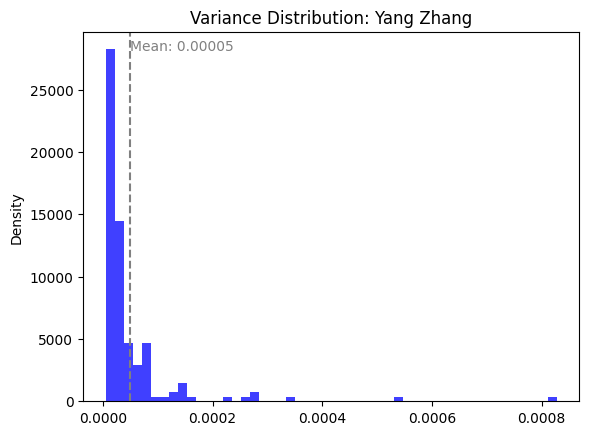

Parkinson: 0.0000182
Garman Klass: 0.0000183
Roger Satchell: 0.0000230
Yang Zhang: 0.0000489
Close to Close: 0.0000671


In [70]:

#same procedure than the cell above

var_means = {}  

for i in range(1, 6):
    x = f'Estimator{i}'
    liste = monthly_var[x].tolist()

    mean_var = np.mean(liste)
    var_means[legends[i-1]] = mean_var  
    density, bins, _ = plt.hist(liste, bins=50, alpha=0.75, color='blue', density=True)
    plt.ylabel('Density')
    plt.axvline(x=mean_var, color='gray', linestyle='--')
    plt.text(mean_var, plt.ylim()[1] * 0.95, f'Mean: {mean_var:.5f}', color='gray', ha='left')
    plt.title(f'Variance Distribution: {legends[i-1]}')
    plt.show()

sorted_means = sorted(var_means.items(), key=lambda item: item[1])
for estimator, variance in sorted_means:
    print(f"{estimator}: {variance:.7f}")


III) Garch model

Garch prediction

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


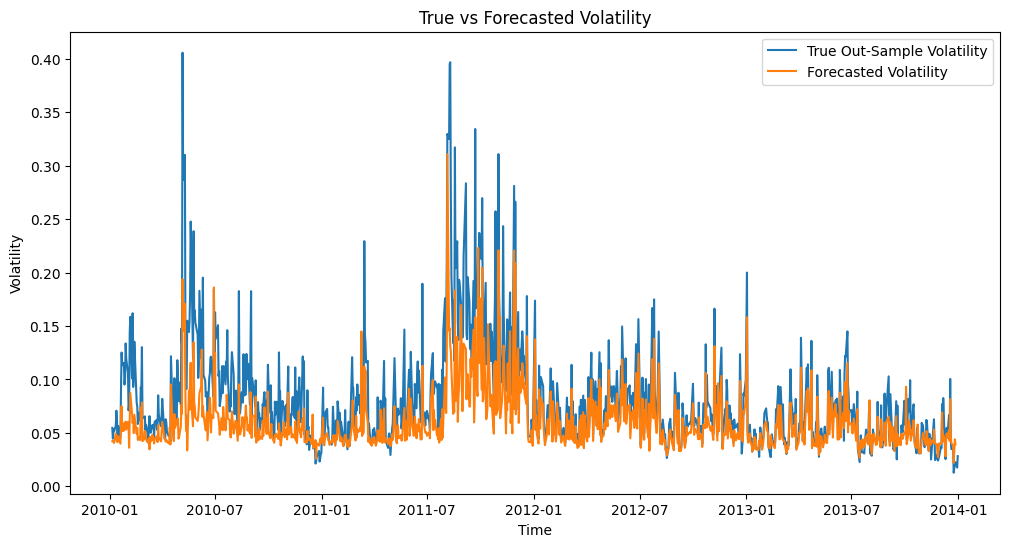

In [73]:

data = pd.read_csv('RealizedVarianceData.csv', low_memory=False)


data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'], errors='coerce')
data = data.dropna(subset=['Unnamed: 0', 'Realized Variance (5-minute)'])


data['Realized Variance (5-minute)'] = pd.to_numeric(data['Realized Variance (5-minute)'], errors='coerce')
data = data.dropna(subset=['Realized Variance (5-minute)'])


data.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
data.set_index('Date', inplace=True)


data['Realized Volatility (5-minute)'] = np.sqrt(data['Realized Variance (5-minute)']*100)


split_date = '2010-01-01'
in_sample = data.loc[:split_date]
out_sample = data.loc[split_date:]

# Parameters
a=2
b=0
# Rolling window forecast
window_size = 1
forecasts = []

for start in range(len(out_sample) - window_size):
    end = start + window_size
    train_data = pd.concat([in_sample['Realized Volatility (5-minute)'], out_sample['Realized Volatility (5-minute)'][:start]])
    
    # Fit the GARCH model
    model = arch_model(train_data, vol='Garch', p=a, q=b)
    model_fit = model.fit(disp='off')
    if b==0:    
       model_fit.params['beta[1]']=0
    last_volatility = train_data.iloc[-1]
    forecast_variance = model_fit.params['omega'] + model_fit.params['alpha[1]'] * (last_volatility ** 2) + model_fit.params['beta[1]'] * model_fit.conditional_volatility[-1] ** 2
    forecast_volatility = np.sqrt(forecast_variance)
    forecasts.append(forecast_volatility)

forecasts = pd.Series(forecasts, index=out_sample.index[window_size:])
forecasts=forecasts.shift(-2)

plt.figure(figsize=(12, 6))
plt.plot(forecasts.index, out_sample['Realized Volatility (5-minute)'][window_size:], label='True Out-Sample Volatility')
plt.plot(forecasts.index, forecasts, label='Forecasted Volatility')
plt.legend()
plt.title('True vs Forecasted Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.show()

Garch study

[*********************100%%**********************]  1 of 1 completed


    Model  p  q   Avg_MSE
0   GARCH  1  1  0.000069
1   GARCH  1  2  0.044667
2   GARCH  1  3  0.000053
3   GARCH  2  1  0.000686
4   GARCH  2  2  0.000066
5   GARCH  2  3  0.000066
6   GARCH  3  1  0.001861
7   GARCH  3  2  0.000072
8   GARCH  3  3  0.000069
9    ARCH  1  0  0.000051
10   ARCH  2  0  0.000054
11   ARCH  3  0  0.000056


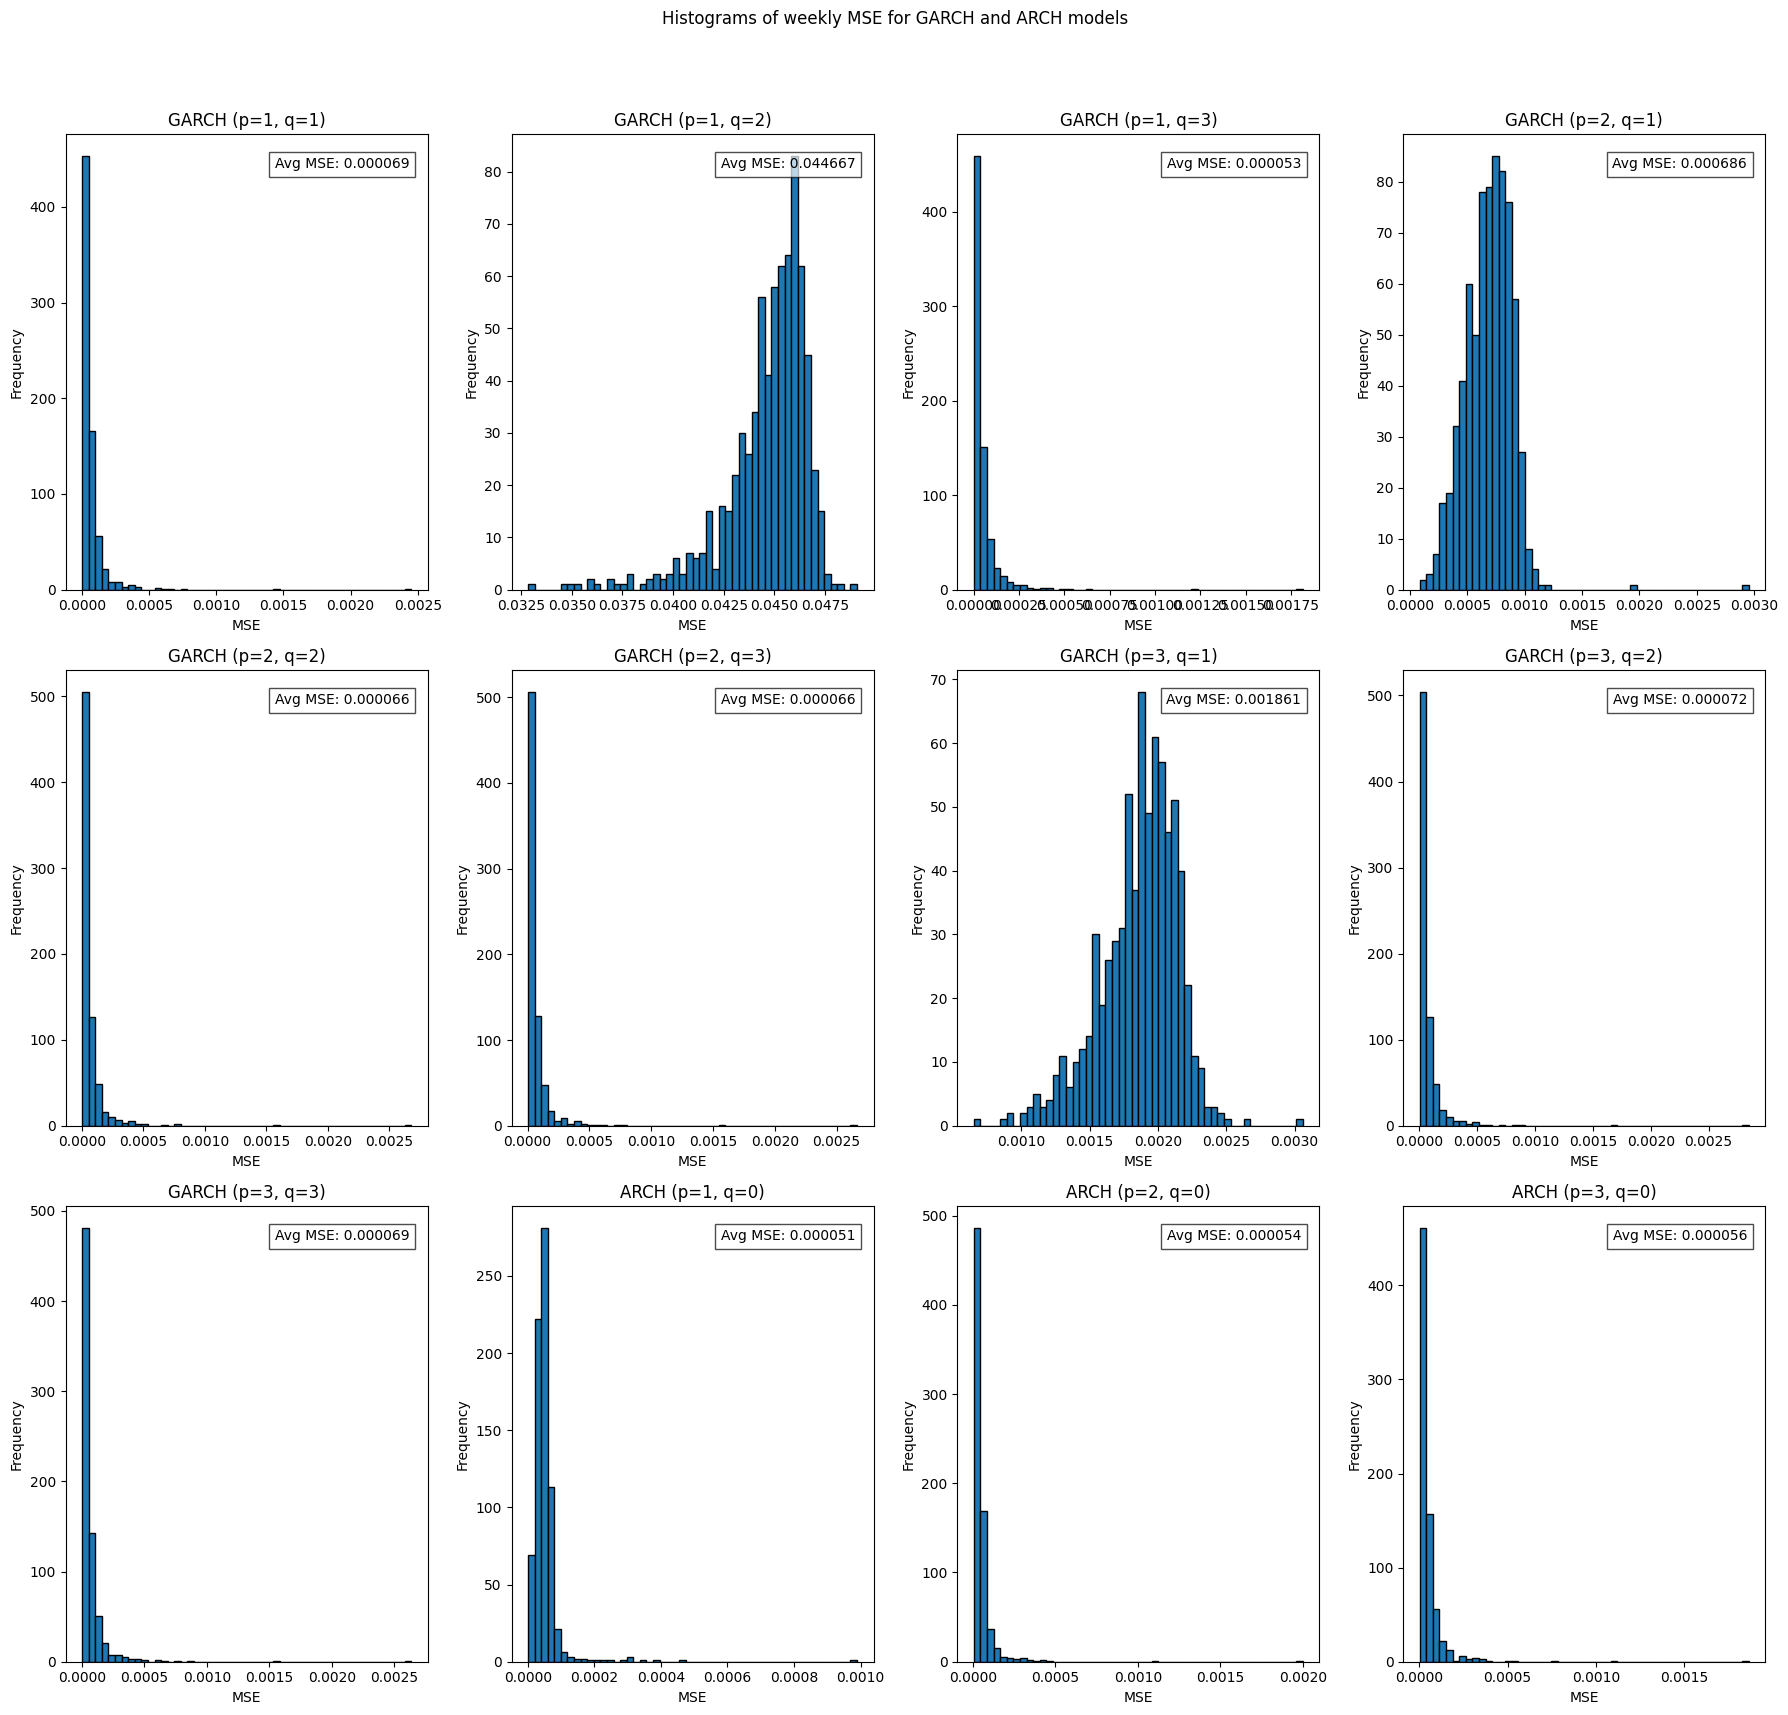

In [ ]:
warnings.filterwarnings("ignore")

def download_data(ticker='SPY', start='2000-01-01', end='2013-12-31'):
    data = yf.download(ticker, start=start, end=end)
    data = data[['Open', 'High', 'Low', 'Close']]
    return data

# GARCH
def apply_garch_model(log_returns, p, q):
    p, q = int(p), int(q)
    model = arch_model(log_returns, vol='Garch', p=p, q=q, rescale=False)
    model_fit = model.fit(disp="off")
    forecasts = model_fit.forecast(horizon=1, start=0)
    predicted_vol = np.sqrt(forecasts.variance.values.flatten())
    return predicted_vol

# ARCH
def apply_arch_model(log_returns, p):
    p = int(p)
    model = arch_model(log_returns, vol='ARCH', p=p, rescale=False)
    model_fit = model.fit(disp="off")
    forecasts = model_fit.forecast(horizon=1, start=0)
    predicted_vol = np.sqrt(forecasts.variance.values.flatten())
    return predicted_vol

# MSE
def calculate_weekly_mse(realized_vol, predicted_vol):
    mse_weekly = ((realized_vol - predicted_vol) ** 2).resample('W').mean()
    return mse_weekly


data = download_data()
    
log_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
    
realized_vol = log_returns.abs()

results = []

# GARCH for p, q in [1, 2, 3]
for p in range(1, 4):
    for q in range(1, 4):
        predicted_vol_garch = apply_garch_model(log_returns, p, q)
        predicted_vol_garch = predicted_vol_garch[-len(realized_vol):]
        mse_weekly_garch = calculate_weekly_mse(realized_vol, predicted_vol_garch)
        avg_mse_garch = mse_weekly_garch.mean()
        results.append(('GARCH', p, q, avg_mse_garch))

# ARCH for p in [1, 2, 3]
for p in range(1, 4):
    predicted_vol_arch = apply_arch_model(log_returns, p)
    predicted_vol_arch = predicted_vol_arch[-len(realized_vol):]
    mse_weekly_arch = calculate_weekly_mse(realized_vol, predicted_vol_arch)
    avg_mse_arch = mse_weekly_arch.mean()
    results.append(('ARCH', p, 0, avg_mse_arch)) 

results_df = pd.DataFrame(results, columns=['Model', 'p', 'q', 'Avg_MSE'])
    
print(results_df)

num_models = len(results_df)
num_cols = 4
num_rows = (num_models + num_cols - 1) // num_cols 

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))
fig.suptitle('Histograms of weekly MSE for GARCH and ARCH models')

for index, (model, p, q, avg_mse) in enumerate(results):
    if model == 'GARCH':
        predicted_vol = apply_garch_model(log_returns, p, q)
    else:
        predicted_vol = apply_arch_model(log_returns, p)
        
    predicted_vol = predicted_vol[-len(realized_vol):]
    mse_weekly = calculate_weekly_mse(realized_vol, predicted_vol)
        
    ax = axs[index // num_cols, index % num_cols]
    ax.hist(mse_weekly.dropna(), bins=50, edgecolor='black')
    ax.set_title(f'{model} (p={p}, q={q})')
    ax.set_xlabel('MSE')
    ax.set_ylabel('Frequency')
    ax.text(0.95, 0.95, f'Avg MSE: {avg_mse:.6f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

for i in range(num_models, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Arch and garch bias

[*********************100%%**********************]  1 of 1 completed


    Model  p  q  Avg_Weekly_Bias
0   GARCH  1  1         0.000066
1   GARCH  1  2         0.000066
2   GARCH  1  3         0.000065
3   GARCH  2  1         0.000066
4   GARCH  2  2         0.000066
5   GARCH  2  3         0.000066
6   GARCH  3  1         0.000066
7   GARCH  3  2         0.000066
8   GARCH  3  3         0.000067
9    ARCH  1  0         0.000056
10   ARCH  2  0         0.000056
11   ARCH  3  0         0.000060


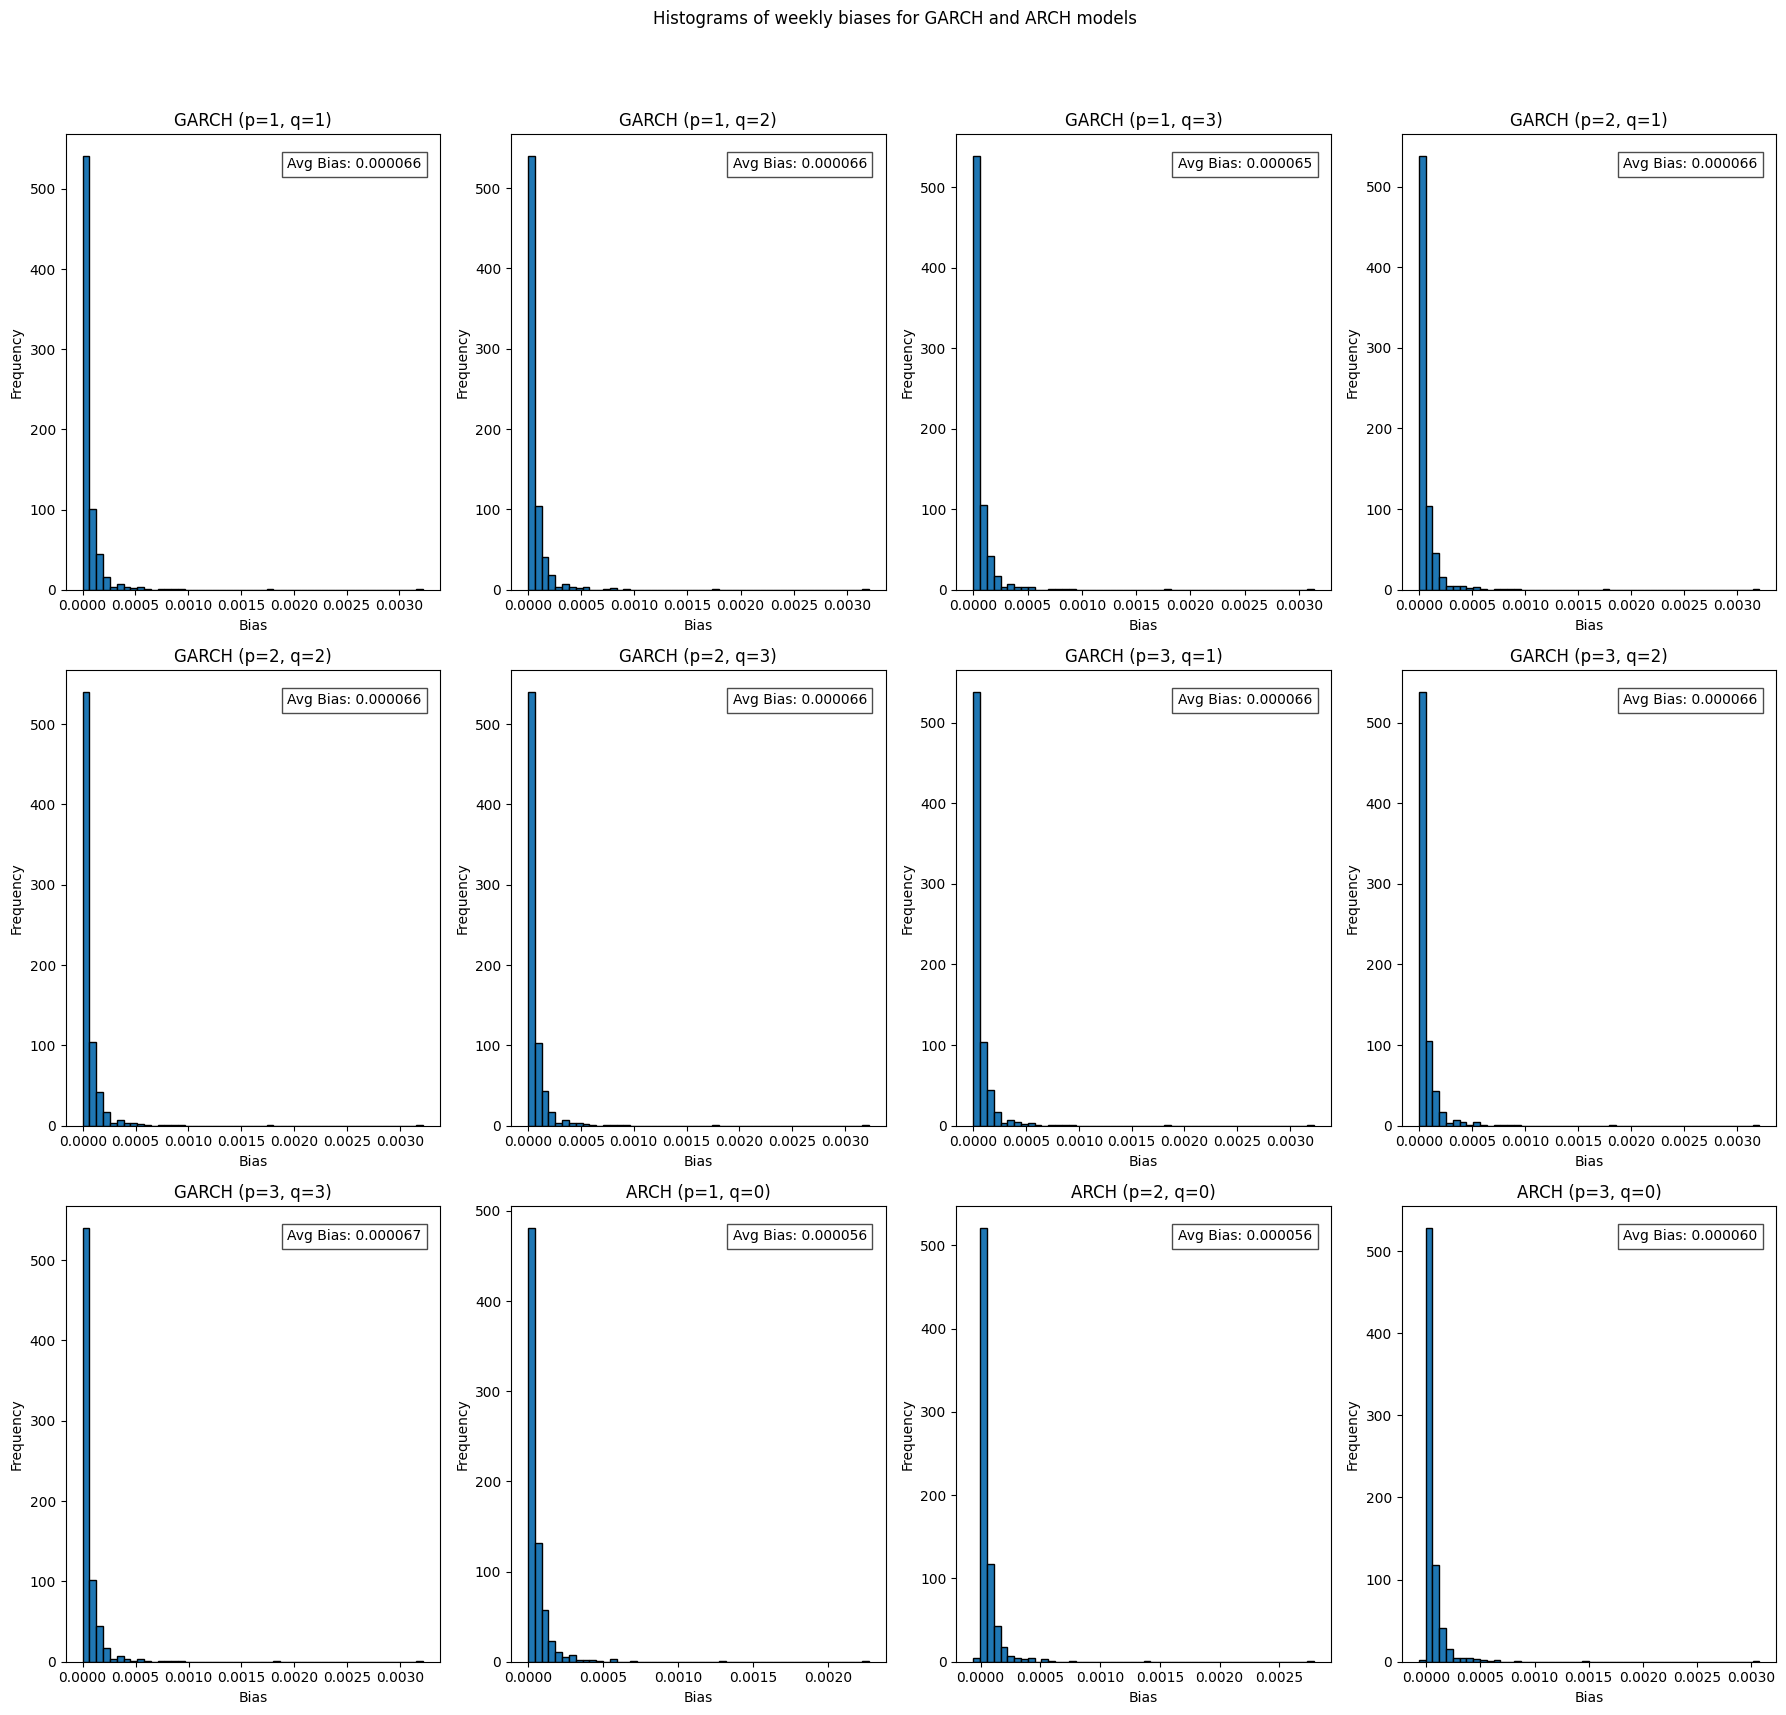

In [ ]:
# weekly variance
def calculate_weekly_variance(volatility, index):
    volatility_series = pd.Series(volatility, index=index)
    var_weekly = volatility_series.resample('W').var()
    return var_weekly

# weekly bias
def calculate_weekly_bias(realized_vol, predicted_vol, index):
    var_realized_weekly = calculate_weekly_variance(realized_vol, index)
    var_predicted_weekly = calculate_weekly_variance(predicted_vol, index)
    bias_weekly = var_realized_weekly - var_predicted_weekly
    return bias_weekly


data = download_data()
    
log_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
    
realized_vol = log_returns.abs()
  
results = []

# GARCH for p, q in [1, 2, 3]
for p in range(1, 4):
    for q in range(1, 4):
        predicted_vol_garch = apply_garch_model(log_returns, p, q)
        predicted_vol_garch = predicted_vol_garch[-len(realized_vol):]
        bias_weekly_garch = calculate_weekly_bias(realized_vol, predicted_vol_garch, realized_vol.index)
        avg_bias_garch = bias_weekly_garch.mean()
        results.append(('GARCH', p, q, avg_bias_garch))

# ARCH for p in [1, 2, 3]
for p in range(1, 4):
    predicted_vol_arch = apply_arch_model(log_returns, p)
    predicted_vol_arch = predicted_vol_arch[-len(realized_vol):]
    bias_weekly_arch = calculate_weekly_bias(realized_vol, predicted_vol_arch, realized_vol.index)
    avg_bias_arch = bias_weekly_arch.mean()
    results.append(('ARCH', p, 0, avg_bias_arch))

results_df = pd.DataFrame(results, columns=['Model', 'p', 'q', 'Avg_Weekly_Bias'])
    
print(results_df)

num_models = len(results_df)
num_cols = 4
num_rows = (num_models + num_cols - 1) // num_cols 

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))
fig.suptitle('Histograms of weekly biases for GARCH and ARCH models')

for index, (model, p, q, avg_bias) in enumerate(results):
    if model == 'GARCH':
        predicted_vol = apply_garch_model(log_returns, p, q)
    else:
        predicted_vol = apply_arch_model(log_returns, p)
        
    predicted_vol = predicted_vol[-len(realized_vol):]
    bias_weekly = calculate_weekly_bias(realized_vol, predicted_vol, realized_vol.index)
        
    ax = axs[index // num_cols, index % num_cols]
    ax.hist(bias_weekly.dropna(), bins=50, edgecolor='black')
    ax.set_title(f'{model} (p={p}, q={q})')
    ax.set_xlabel('Bias')
    ax.set_ylabel('Frequency')
    ax.text(0.95, 0.95, f'Avg Bias: {avg_bias:.6f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

for i in range(num_models, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Arch and garch variance

[*********************100%%**********************]  1 of 1 completed


    Model  p  q  Avg_Weekly_Variance
0   GARCH  1  1         7.864438e-07
1   GARCH  1  2         1.588483e-06
2   GARCH  1  3         2.357908e-06
3   GARCH  2  1         1.112587e-06
4   GARCH  2  2         1.094078e-06
5   GARCH  2  3         9.757249e-07
6   GARCH  3  1         7.981670e-07
7   GARCH  3  2         1.002683e-06
8   GARCH  3  3         6.245980e-07
9    ARCH  1  0         1.089090e-05
10   ARCH  2  0         1.076910e-05
11   ARCH  3  0         7.464606e-06


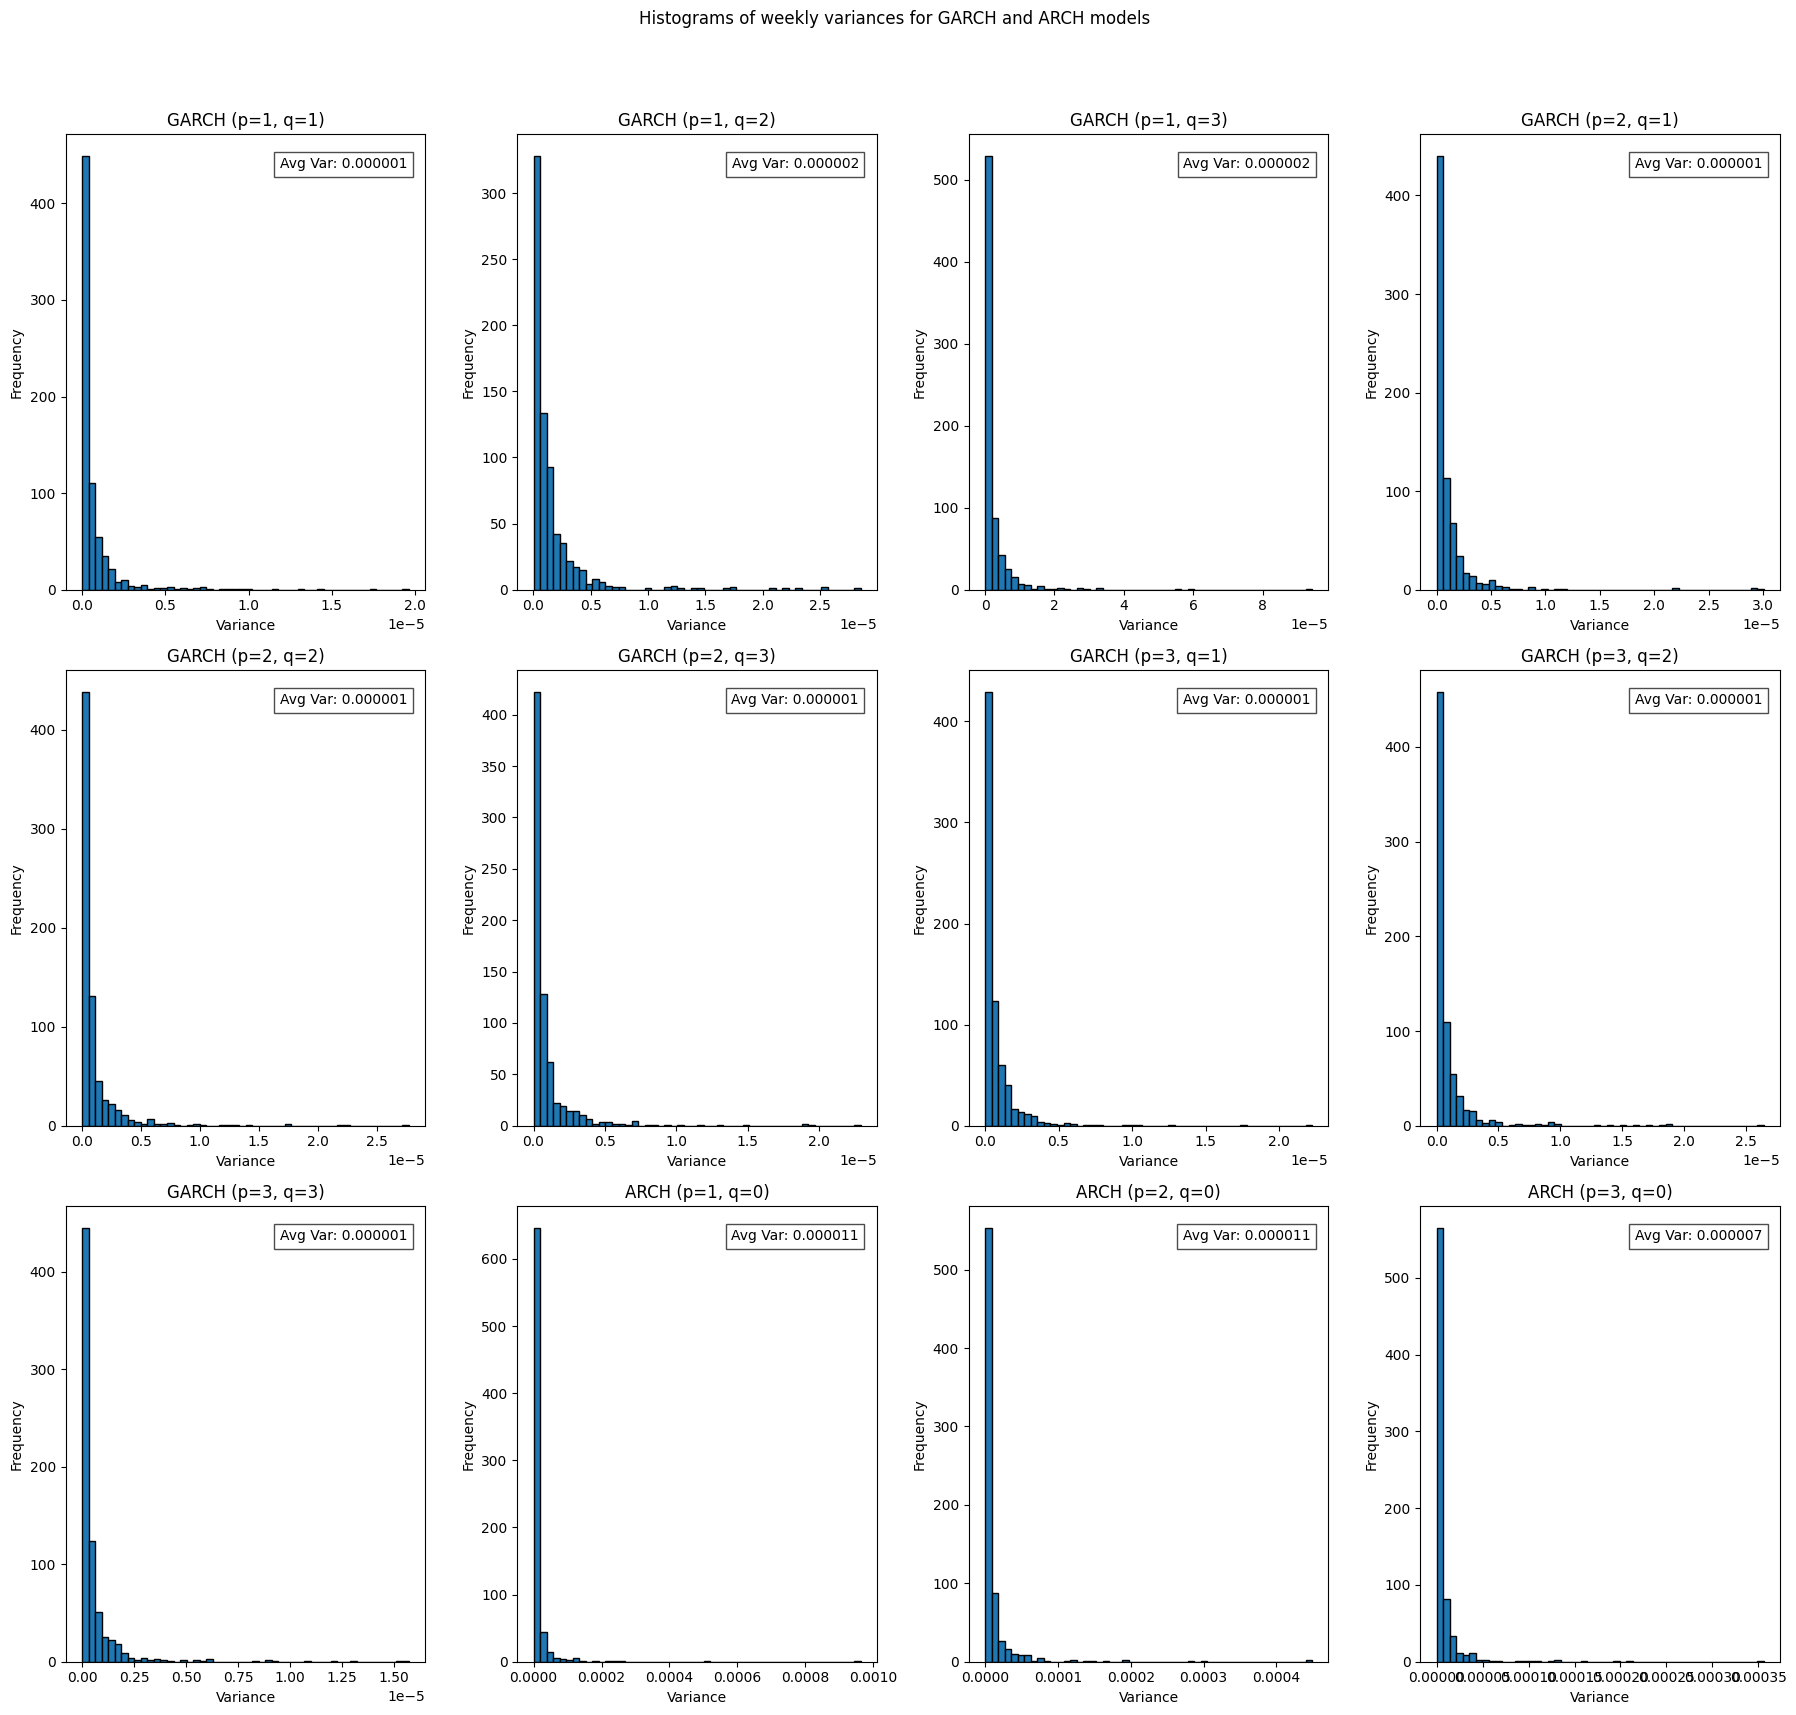

In [ ]:
data = download_data()
    
log_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
    
realized_vol = log_returns.abs()

results = []

# GARCH for p, q in [1, 2, 3]
for p in range(1, 4):
    for q in range(1, 4):
        predicted_vol_garch = apply_garch_model(log_returns, p, q)
        predicted_vol_garch = predicted_vol_garch[-len(realized_vol):]
        var_weekly_garch = calculate_weekly_variance(predicted_vol_garch, realized_vol.index)
        avg_var_garch = var_weekly_garch.mean()
        results.append(('GARCH', p, q, avg_var_garch))

# ARCH for p in [1, 2, 3]
for p in range(1, 4):
    predicted_vol_arch = apply_arch_model(log_returns, p)
    predicted_vol_arch = predicted_vol_arch[-len(realized_vol):]
    var_weekly_arch = calculate_weekly_variance(predicted_vol_arch, realized_vol.index)
    avg_var_arch = var_weekly_arch.mean()
    results.append(('ARCH', p, 0, avg_var_arch))

results_df = pd.DataFrame(results, columns=['Model', 'p', 'q', 'Avg_Weekly_Variance'])
    
print(results_df)

num_models = len(results_df)
num_cols = 4
num_rows = (num_models + num_cols - 1) // num_cols 

fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 6))
fig.suptitle('Histograms of weekly variances for GARCH and ARCH models')

for index, (model, p, q, avg_var) in enumerate(results):
    if model == 'GARCH':
        predicted_vol = apply_garch_model(log_returns, p, q)
    else:
        predicted_vol = apply_arch_model(log_returns, p)
        
    predicted_vol = predicted_vol[-len(realized_vol):]
    var_weekly = calculate_weekly_variance(predicted_vol, realized_vol.index)
        
    ax = axs[index // num_cols, index % num_cols]
    ax.hist(var_weekly.dropna(), bins=50, edgecolor='black')
    ax.set_title(f'{model} (p={p}, q={q})')
    ax.set_xlabel('Variance')
    ax.set_ylabel('Frequency')
    ax.text(0.95, 0.95, f'Avg Var: {avg_var:.6f}', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

for i in range(num_models, num_rows * num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Day 2

I) Simulation of a rough volatility process 

In [ ]:
nu,X0,alpha=0.3,-5,5*10**(-4)
m=X0
H=0.147
def log_vol(T,lag,H):
    delta=lag/252
    N=int(T/delta)
    X=np.zeros(N)
    X[0]=X0
    W = fbm(N-1, H, length=T, method='daviesharte')
    for i in range(len(W)-1):
        X[i+1]=X[i]+(W[i+1]-W[i])*nu+alpha*(m-X[i])*delta
    return(X)

def hist(X_simu):
    res=50
    A,B,C,D=np.array([]),np.array([]),np.array([]),np.array([])
    for i in X_simu:
        A = np.concatenate((A, np.diff(i[::1*10**3])))
        B = np.concatenate((B, np.diff(i[::5*10**3])))
        C = np.concatenate((C, np.diff(i[::25*10**3])))
        D = np.concatenate((D, np.diff(i[::125*10**3])))
    plt.subplot(2, 2, 1)
    plt.hist(np.diff(A),res,label="1 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2.6])
    plt.legend()
    plt.title("The distribution of the log-volatility increments for H = "+str(H))

    plt.subplot(2,2,2)
    plt.hist(np.diff(B),res,label="5 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2.6])
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.hist(np.diff(C),res,label="25 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2.6])
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.hist(np.diff(D),res,label="125 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2.6])
    plt.legend()
    plt.show()

Simulating a huge amount of data

In [ ]:
X_simu=np.array([log_vol(1,10**(-3),0.147) for i in range(60)])

Distribution of log-volatility increments

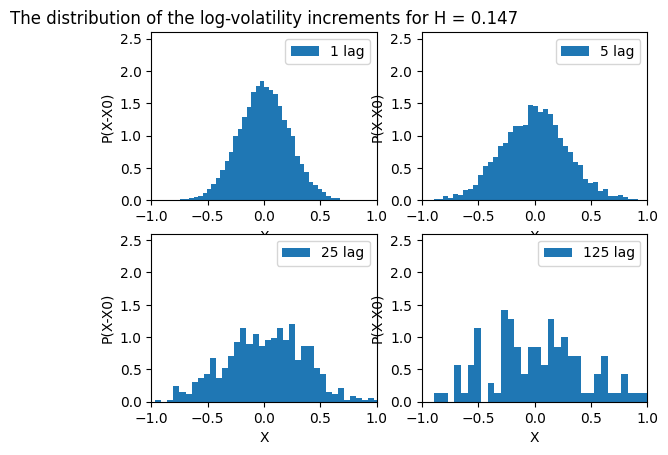

In [ ]:
hist(X_simu)

We see that the distribution of the log-volatility increments is close to a Gaussian.


2) A method to determine the H exponent

In [ ]:
def M(X,q,lag):
    a=np.mean(abs(np.diff(X[::int(lag)]))**q)
    return(a)

def H_exp_model(X_sim,plot):
    Delta=np.arange(1,251,1)
    Q=[0.5,1,1.5,2,3]
    Y=np.zeros(len(Delta)) 
    h_exp=0
    for q in Q:
        i=0
        for d in Delta:
            Em=0
            for X in X_sim:
                Em+=M(X,q,d)
            Y[i]=Em/len(X_sim)
            i+=1
        Y=np.log10(Y)
        slope, intercept,a,b,c= stats.linregress(np.log10(Delta),Y)
        x=[0,2.5]
        y=[0*slope+intercept,2.5*slope+intercept]
        plt.plot(x,y)
        h_exp+=slope/q/len(Q)
        plt.scatter(np.log10(Delta),Y,marker=".",s=10)
    plt.title("H theoric = "+str(H)+", H experimental = "+str(h_exp))
    plt.xlabel(r"$\log(\Delta)$")
    plt.ylabel(r"$\log(m(q,\Delta))$")
    if plot:
        plt.show()
    else:
        plt.clf()
    return(h_exp)

Scaling of the moments and monofractality


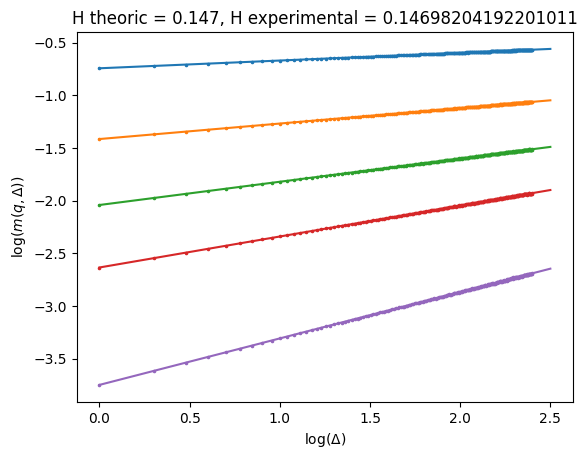

0.14698204192201011

In [ ]:
H_exp_model(X_simu,True)

Importing real datas

In [ ]:
a=pd.read_csv("RealizedVarianceData.csv",skiprows=[0])
D=a["SPX2.rv"].tolist()

for k in range(len(D)):
    if str(D[k])=="nan":
        D[k]=D[k-1]
d=np.log10(D)
a["DateID"] = pd.to_datetime(a['DateID'],format='%Y%m%d')
a['year'] = pd.DatetimeIndex(a['DateID']).year
years = set(a["year"].values)
T=[]
for year in years:
    dyear= a[a["year"] == year]["SPX2.rv"].tolist()
    dyear=np.log10(dyear)
    for k in range(len(dyear)):
        if str(dyear[k])=="nan":
            dyear[k]=dyear[k-1]
    T.append(dyear)

In [ ]:
def H_exp(X,plot):
    Delta=np.logspace(1,2.1,100)
    Q=[0.5,0.75,1,1.25,1.5,2]
    Y=np.zeros(len(Delta))   
    h_exp=0
    for q in Q:
        i=0
        for d in Delta:   
            Em=M(X,q,d)
            Y[i]=Em
            i+=1
        Y=np.log10(Y)
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(Delta),Y)
        x=[1,2.1]
        y=[1*slope+intercept,2.1*slope+intercept]
        plt.plot(x,y)
        h_exp+=slope/q/len(Q)
        plt.scatter(np.log10(Delta),Y,marker=".",s=10)
    plt.title("H experimental = "+str(h_exp))
    plt.xlabel(r"$\log(\Delta)$")
    plt.ylabel(r"$\log(m(q,\Delta))$")
    if plot:
        plt.show()
    else:
        plt.clf()
    return(h_exp)

def histo(X):
    plt.subplot(2, 2, 1)
    plt.hist(np.diff(X[::1]),30,label="1 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2])
    plt.legend()
    plt.title("The distribution of the log-volatility increments")

    plt.subplot(2,2,2)
    plt.hist(np.diff(X[::3]),30,label="3 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2])
    plt.legend()


    plt.subplot(2, 2, 3)
    plt.hist(np.diff(X[::10]),30,label="10 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2])
    plt.legend()


    plt.subplot(2, 2, 4)
    plt.hist(np.diff(X[::30]),30,label="30 lag",density=True)
    plt.xlabel("X")
    plt.ylabel("P(X-X0)")
    plt.xlim([-1,1])
    plt.ylim([0,2])
    plt.legend()
    plt.show()

def moving_average_exp(table,t,L):
    slice=table[t:L*260+t]
    return H_exp(slice,False)

def moving_average_simu(X_sim,t):
    n=int(len(X_sim[0])/2)
    slice=X_sim[:,t:n+t]
    return H_exp_model(slice,False)

Now with real data

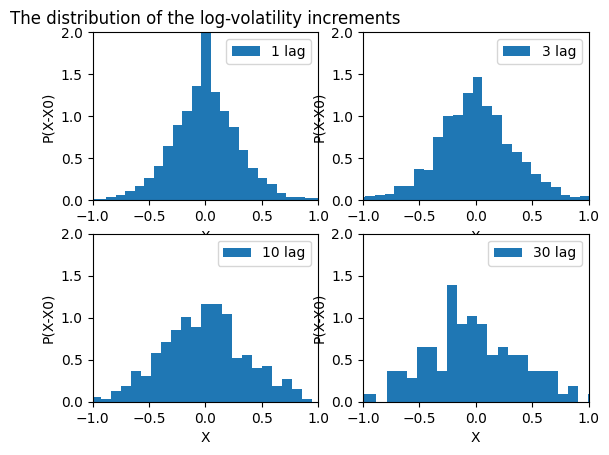

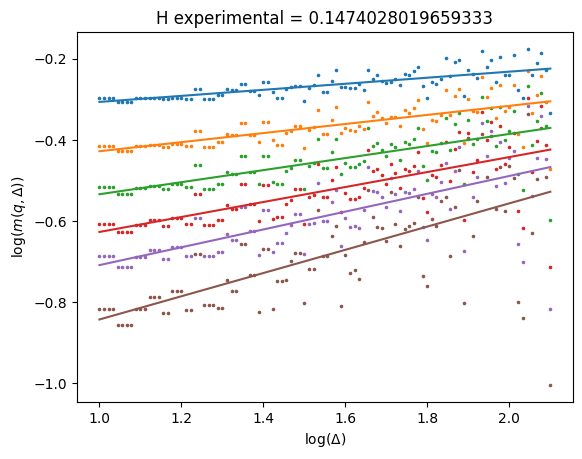

In [ ]:
histo(d)
h_exp=H_exp(d,True)

Illustrating H-time dependancy

In [ ]:
H=0.147402801965937
#14 years
L=9
Delta=np.arange(0,(14-L)*260,10)
Y,Z=[],[]
jump=2100000/((14-L)*260)
for delta in Delta:
    Y.append(moving_average_exp(d,int(delta),L))
    Z.append(moving_average_simu(X_simu[:1],int(jump*(delta))))

<Figure size 640x480 with 0 Axes>

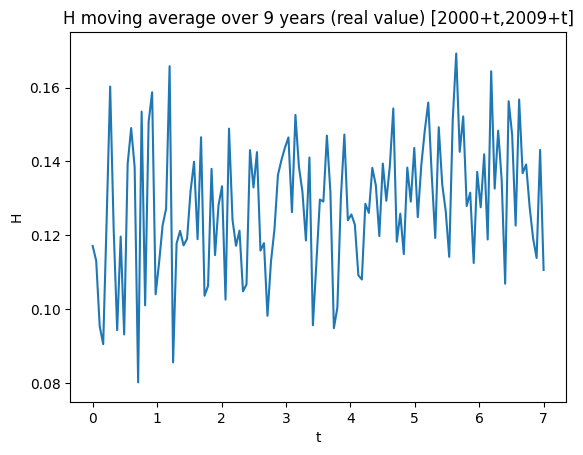

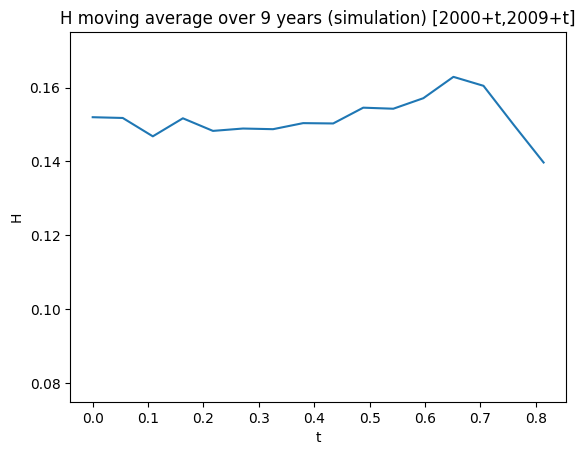

In [ ]:
T=np.linspace(0,7,len(Y))

plt.title(f"H moving average over {L} years (real value) [2000+t,2009+t]")
plt.xlabel("t")
plt.ylabel("H")
plt.plot(T,Y)
plt.ylim([0.075,0.175])
plt.show()
plt.plot(T,Z)
plt.title(f"H moving average over {L} years (simulation) [2000+t,2009+t]")
plt.xlabel("t")
plt.ylabel("H")
plt.ylim([0.075,0.175])
plt.show()


In [ ]:
def pred_sigma(log_sigmasquare,delta,H):
    pred = 0
    coeff=((delta**(H+1/2))*np.cos(H*np.pi)/np.pi)
    for k in range(len(log_sigmasquare)):
        d=(k+delta+1/2)*((k+1/2)**(H+1/2))
        a=log_sigmasquare[-k-1]/d
        pred+=a
    return(pred*coeff)

def P(delta):
    dtilde=d[delta:]
    X=np.array([pred_sigma(d[:k+1],delta,H) for k in range(len(d)-delta)]) #X[k]=log sigma [k+delta]
    bias=np.mean(dtilde/X)
    return(1-r2_score(dtilde,X*bias))

def plot(delta):
    dtilde=d[delta:]
    X=np.array([pred_sigma(d[:k+1],delta,H) for k in range(len(d)-delta)])
    plt.plot(dtilde,label="Real")
    plt.plot(X*np.mean(dtilde/X),label="Pred")
    plt.legend()
    plt.show()


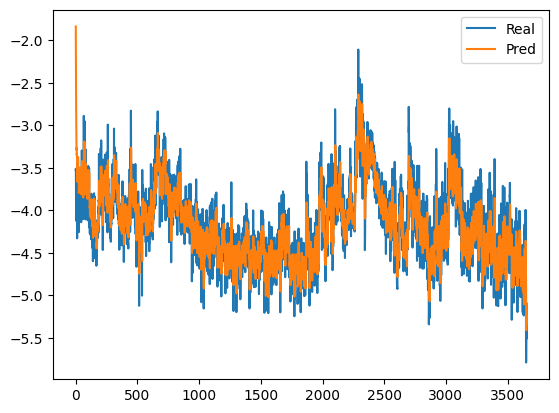

0.32013212738145524


In [ ]:
plot(1)
print(P(1))

The P score obtained for $\Delta=1$ is 0.32 

Autocorrelation structures

In [ ]:
X_14=np.array([log_vol(14,1,0.147) for i in range(50)])

In [ ]:
def autocorr_empirique(x,delta):
    mean = np.mean(x)
    n=len(x)
    z=(x[:n-delta]-mean)*(x[delta:]-mean)
    return(np.mean(z))

def autocorr(x_simu,delta):
    mea=0
    for x in x_simu:
        mea+=autocorr_empirique(x,delta)
    return(mea/len(x_simu))

a=X_simu[:,:8000]
a=a**10
Delta=np.arange(1000)
Delta2=np.arange(len(D)-2600)

A1=[autocorr(a,delta) for delta in Delta]

B1=[np.log10(autocorr(a,delta)) for delta in Delta]

C1=[autocorr(np.log10(a),delta) for delta in Delta]

A2=[autocorr_empirique(D,delta) for delta in Delta2]

B2=[np.log10(autocorr_empirique(D,delta)) for delta in Delta2]

C2=[autocorr_empirique(np.log10(D),delta) for delta in Delta2]

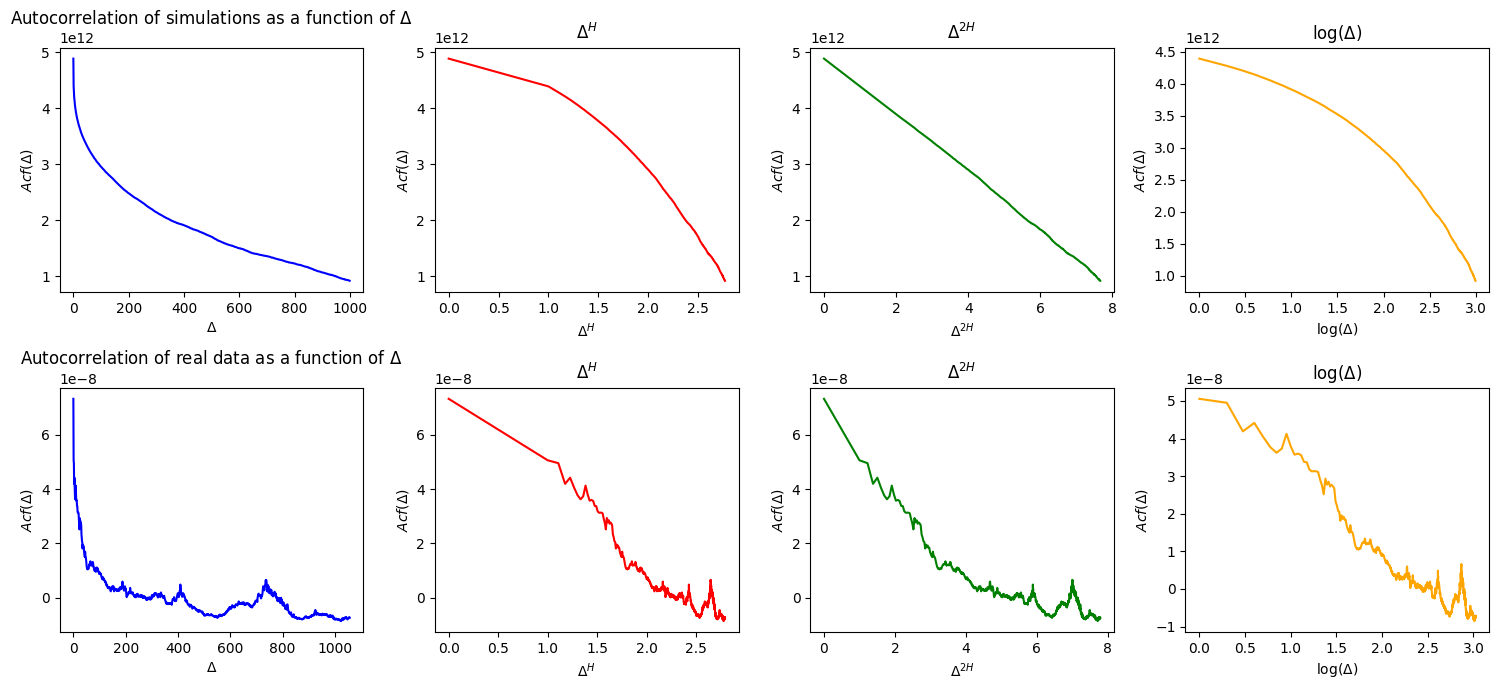

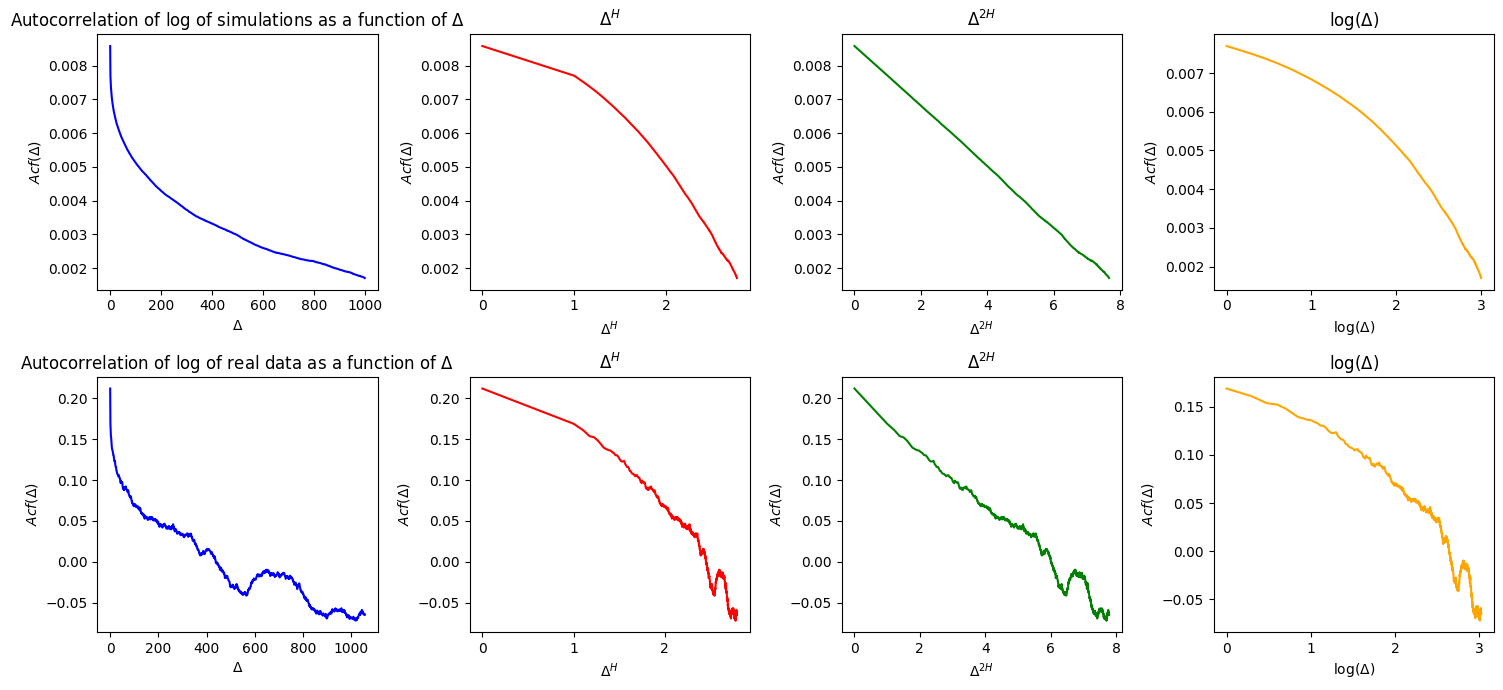

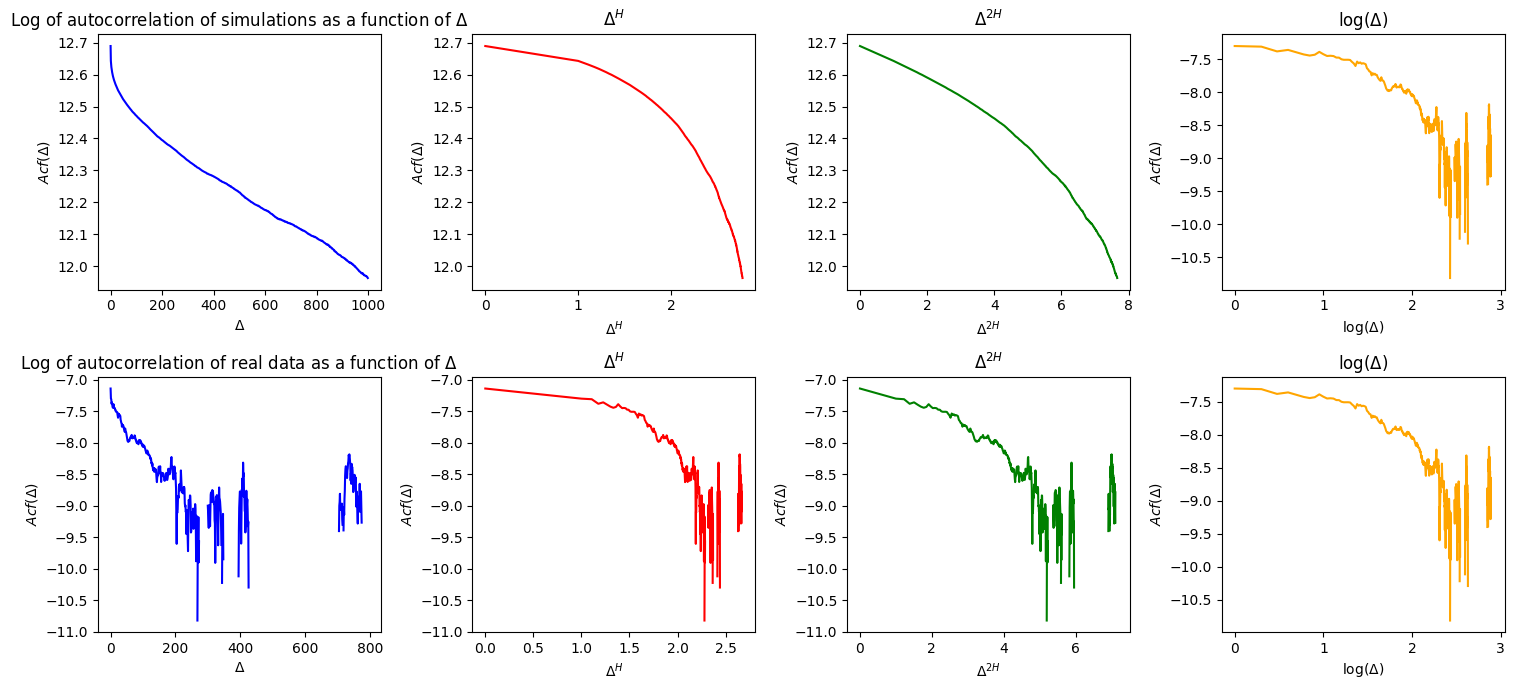

In [ ]:
plt.figure(figsize=(15, 7))

plt.subplot(2, 4, 1)
plt.plot(Delta,A1, color='blue')
plt.title(r'Autocorrelation of simulations as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 2) 
plt.plot(Delta**H,A1, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 3) 
plt.plot(Delta**(2*H),A1, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 4) 
plt.plot(np.log10(Delta),A1, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")

plt.subplot(2, 4, 5)
plt.plot(Delta2,A2, color='blue')
plt.title(r'Autocorrelation of real data as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 6)
plt.plot(Delta2**H,A2, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 7)
plt.plot(Delta2**(2*H),A2, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 8)
plt.plot(np.log10(Delta2),A2, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")


plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 7))

plt.subplot(2, 4, 1)
plt.plot(Delta,C1, color='blue')
plt.title(r'Autocorrelation of log of simulations as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 2) 
plt.plot(Delta**H,C1, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 3) 
plt.plot(Delta**(2*H),C1, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 4) 
plt.plot(np.log10(Delta),C1, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")

plt.subplot(2, 4, 5)
plt.plot(Delta2,C2, color='blue')
plt.title(r'Autocorrelation of log of real data as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 6)
plt.plot(Delta2**H,C2, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 7)
plt.plot(Delta2**(2*H),C2, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 8)
plt.plot(np.log10(Delta2),C2, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 7))

plt.subplot(2, 4, 1)
plt.plot(Delta,B1, color='blue')
plt.title(r'Log of autocorrelation of simulations as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 2) 
plt.plot(Delta**H,B1, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 3) 
plt.plot(Delta**(2*H),B1, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 4)
plt.plot(np.log10(Delta2),B2, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")

plt.subplot(2, 4, 5)
plt.plot(Delta2,B2, color='blue')
plt.title(r'Log of autocorrelation of real data as a function of $\Delta$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta$")

plt.subplot(2, 4, 6)
plt.plot(Delta2**H,B2, color='red')
plt.title(r'$\Delta^H$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^H$")

plt.subplot(2, 4, 7)
plt.plot(Delta2**(2*H),B2, color='green')
plt.title(r'$\Delta^{2H}$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\Delta^{2H}$")

plt.subplot(2, 4, 8)
plt.plot(np.log10(Delta2),B2, color='orange')
plt.title(r'$\log(\Delta)$')
plt.ylabel(r"$Acf(\Delta)$")
plt.xlabel(r"$\log(\Delta)$")

plt.tight_layout()
plt.show()



We observe that ACF as a function of $\Delta^{2H}$ is linear

In [ ]:
data=pd.read_csv('/Users/nicolas/Desktop/EI/RealizedVarianceData.csv')["Realized Variance (5-minute)"].tolist()[1:]

def pred_sigma2(sigmasquare, delta, H):
    log_sigmasquare=np.array([np.log10(float(x)) for x in sigmasquare])
    pred = 0
    coeff=((delta**(H+1/2))*np.cos(H*np.pi)/np.pi)
    for k in range(len(log_sigmasquare)):
        b=(k+delta+1/2)*((k+1/2)**(H+1/2))
        a=log_sigmasquare[-k-1]/b
        pred+=a
    return(pred*coeff)

l=[(pred_sigma2(data[:k], 1, 0.147402801965937)+ 2.04749) for k in range (len(data))]
F = pd.Series(l)

### Calculation of the correlation between the rough volatility estimator and the true volatility

In [ ]:
#preparation of the data and filtering of the NaN values

a=pd.read_csv("RealizedVarianceData.csv",skiprows=[0])
d=a["SPX2.rv"].tolist()
for k in range(len(d)):
    if str(d[k])=="nan":
        d[k]=d[k-1]

true_volatility = pd.Series(d)

true_variance = true_volatility.var()

print("Correlation with True Volatility:\n", pd.Series(F).corr(true_volatility))

Correlation with True Volatility:
 0.40851701905802623


### Calculation and plotting of the monthly MSE for the rough volatility estimator

[*********************100%%**********************]  1 of 1 completed


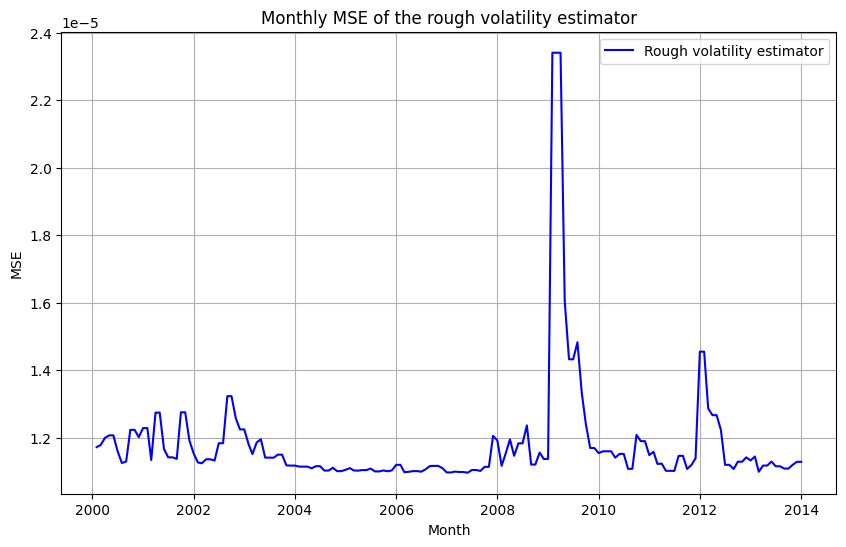

In [ ]:
#preparation of the data and filtering of the NaN values
for k in range(len(l)):
    if str(l[k])=="nan":
        l[k]=l[k-1]

data = yf.download('SPY', start='2000-01-01', end='2014-01-01')
data.index = pd.to_datetime(data.index)

data['Frac'] = pd.Series(l).tolist()[:3521]

data['True_Volatility'] = pd.Series([0]+d).tolist()[:3521]
monthly_true_volatility = data['True_Volatility'].resample('M').mean()

def calculate_monthly_mse(estimator, true_volatility):
    return ((estimator - true_volatility) ** 2).resample('M').mean()

monthly_mse=calculate_monthly_mse(data['Frac'], monthly_true_volatility)

plt.figure(figsize=(10, 6))
plt.plot(monthly_mse.index.tolist(), monthly_mse.fillna(method='bfill').tolist(), label='Rough volatility estimator', color='blue')
plt.title('Monthly MSE of the rough volatility estimator')
plt.xlabel('Month')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()



### Plotting of the MSE distribution of the rough volatility estimator

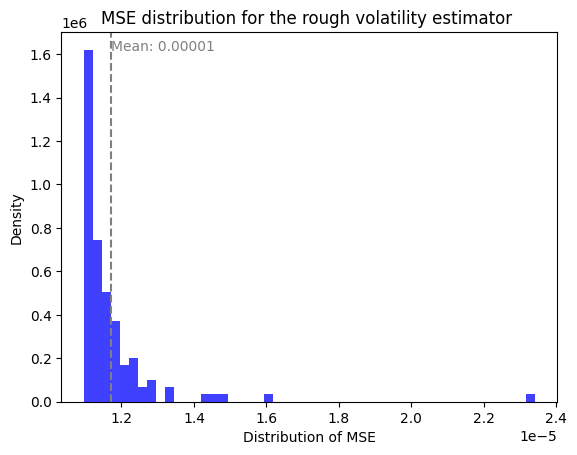

In [ ]:
liste = monthly_mse.dropna().tolist()

mean_mse = np.mean(liste) 

density, bins, _ = plt.hist(liste, bins=50, alpha=0.75, color='blue', density=True)
plt.xlabel(f'Distribution of MSE')
plt.ylabel('Density')
plt.axvline(x=mean_mse, color='gray', linestyle='--')
plt.text(mean_mse, plt.ylim()[1] * 0.95, f'Mean: {mean_mse:.5f}', color='gray', ha='left')
plt.title(f'MSE distribution for the rough volatility estimator ')
plt.show()

### Plotting of the variance distribution of the rough volatility estimator

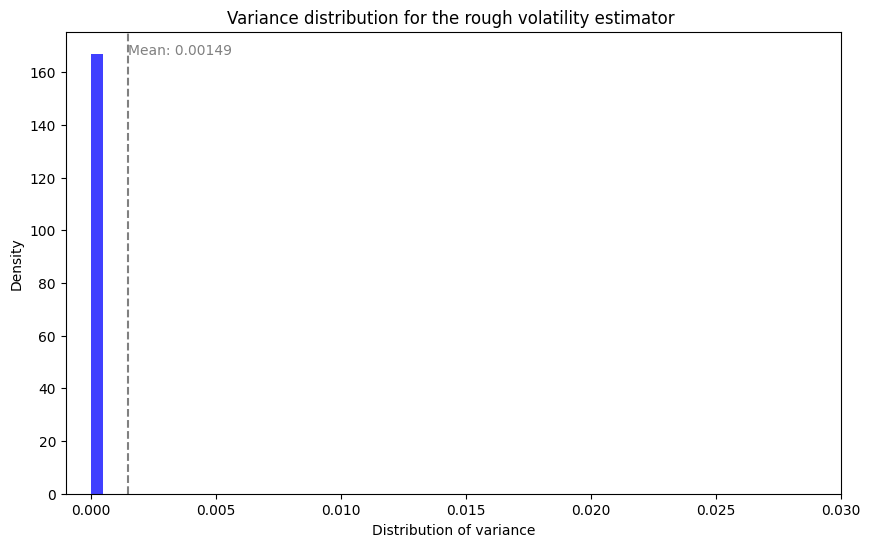

In [ ]:
def calculate_monthly_var(estimator):
    return estimator.resample('M').var()

monthly_var=calculate_monthly_var(data['Frac'])
liste = monthly_var.dropna().tolist()
mean_var = np.mean(liste) 
    
plt.figure(figsize=(10, 6))
density, bins, _ = plt.hist(liste, bins=500, alpha=0.75, color='blue')
plt.xlabel(f'Distribution of variance')
plt.ylabel('Density')
plt.axvline(x=mean_var, color='gray', linestyle='--')
plt.text(mean_var, plt.ylim()[1] * 0.95, f'Mean: {mean_var:.5f}', color='gray', ha='left')
plt.title(f'Variance distribution for the rough volatility estimator ')
plt.xlim([-0.001,0.03])
plt.show()

### Plotting of the bias distribution of the rough volatility estimator

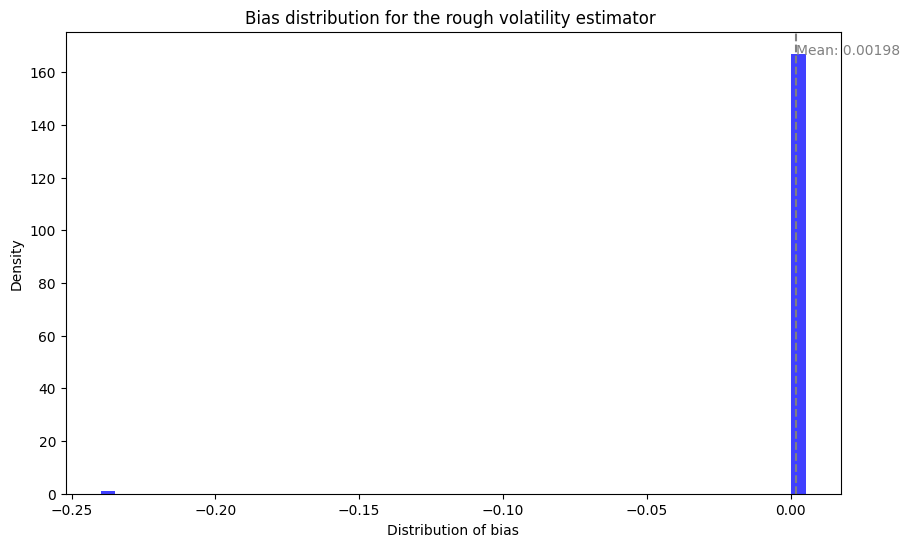

In [ ]:
def calculate_monthly_mean(estimateur):
    return estimateur.resample('M').mean()

def calculate_monthly_bias(estimator, true_volatility):
    return (true_volatility-calculate_monthly_mean(estimator))

monthly_bias=calculate_monthly_bias(data['Frac'], monthly_true_volatility)
liste=monthly_bias.tolist()
mean_bias = np.mean(liste) 
    
plt.figure(figsize=(10, 6))
density, bins, _ = plt.hist(liste, bins=50, alpha=0.75, color='blue')
plt.xlabel(f'Distribution of bias')
plt.ylabel('Density')
plt.title(f'Bias distribution for the rough volatility estimator ')
plt.axvline(x=mean_bias, color='gray', linestyle='--')
plt.text(mean_bias, plt.ylim()[1] * 0.95, f'Mean: {mean_bias:.5f}', color='gray', ha='left')
plt.show()